# 美国议员议题曝光行为预测分析

本笔记本分析美国议员在不同议题上推动媒体曝光议题的行为模式，通过LightGBM模型预测议员的曝光倾向，并识别影响曝光行为的关键因素。

## 分析目标
- 预测美国议员在特定议题上的曝光行为
- 识别影响议员曝光决策的关键特征  
- 分析国际响应型、专业选择型、利益兑现型三种曝光动机模式

## 数据说明
- **标签（label）**: 议员是否在该议题上进行媒体曝光（1=曝光，0=不曝光）
- **特征**: 包括议员基础信息、议题特征、选区特征、匹配特征等

## 目录
1. [数据准备](#数据准备)
2. [特征工程](#特征工程)
3. [模型训练](#模型训练)
4. [模型评估](#模型评估)
5. [SHAP解释性分析](#SHAP解释性分析)
6. [决策模式分析](#决策模式分析)
7. [排名分析](#排名分析)

# 1. 数据准备

## 1.1 导入必要的库
导入数据处理、机器学习和可视化所需的Python库。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [
    'PingFang SC',            # macOS
    'Hiragino Sans GB',       # macOS
    'Noto Sans CJK SC',       # 全平台（需安装）
    'Microsoft YaHei',        # Windows
    'WenQuanYi Zen Hei',      # Linux
    'Apple LiGothic'          # 兜底
] # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

import warnings
warnings.filterwarnings('ignore')

## 1.2 加载数据
加载美国议员曝光行为训练数据，了解数据的基本结构和特征分布。

In [2]:
origin_data = pd.read_csv("output/adver_train_data.csv")
data = origin_data
data.shape

(58464, 53)

## 1.3 数据概览
查看数据的列名和基本信息，了解特征分布和数据质量。

In [3]:
data.columns

Index(['issue', 'leverage', 'state_code', 's_committee_tp1', 's_committee_tp2',
       's_committee_tp3', 'h_committee_tp1', 'h_committee_tp2',
       'h_committee_tp3', 'party_tp_type', 'party_tp_score', 'industry_tp1',
       'industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'full_name', 'congress', 'age', 'gender', 'party',
       'chamber', 'seniority', 'ideology', 'committee_el', 'district',
       'employ1', 'employ2', 'employ3', 'payroll1', 'payroll2', 'payroll3',
       'ethnicity1', 'ethnicity2', 'ethnicity3', 'ppvi', 'npvi', 'leverage_pl',
       'leverage_ne', 'committee_pl', 'committee_ne', 'employ_industry_pl',
       'employ_industry_ne', 'payroll_industry_pl', 'payroll_industry_ne',
       'ethnicity_pl', 'ethnicity_ne', 'party_value_pl', 'party_value_ne',
       'party_score_pl', 'party_score_ne', 'label'],
      dtype='object')

In [4]:
# 数据列名分类整理
columns_by_category = {
    # 标识信息
    "标识信息": [
        'issue',           # 议题名称
        'full_name',       # 议员姓名  
        'congress',        # 国会届数
        'label'            # 标签
    ],
    
    # 基础议员特征
    "基础议员特征": [
        'age',             # 年龄
        'gender',          # 性别
        'party',           # 党派
        'chamber',         # 议院
        'seniority',       # 资历
        'ideology',        # 意识形态
        'committee_el',    # 议员委员会
        'district',         # 选区
        'state_code',           # 州
    ],
    
    # 议题特征
    "议题特征": [
        'leverage',        # 议题国际压力值
        'party_tp_type',   # 政党偏好类别
        'party_tp_score',  # 政党偏好分数
    ],
    
    # 议题委员会特征
    "议题委员会特征": [
        's_committee_tp1', # 参议院委员会1
        's_committee_tp2', # 参议院委员会2
        's_committee_tp3', # 参议院委员会3
        'h_committee_tp1', # 众议院委员会1
        'h_committee_tp2', # 众议院委员会2
        'h_committee_tp3'  # 众议院委员会3
    ],
    
    # 议题产业特征
    "议题产业特征": [
        'industry_tp1',    # 产业卷入度1
        'industry_tp2',    # 产业卷入度2
        'industry_tp3'     # 产业卷入度3
    ],
    
    # 议题族裔特征
    "议题族裔特征": [
        'ethnicity_tp1',   # 族裔卷入度1
        'ethnicity_tp2',   # 族裔卷入度2
        'ethnicity_tp3'    # 族裔卷入度3
    ],
    
    # 选区产业特征
    "选区产业特征": [
        'employ1',         # 雇佣产业1
        'employ2',         # 雇佣产业2
        'employ3',         # 雇佣产业3
        'payroll1',        # 金主产业1
        'payroll2',        # 金主产业2
        'payroll3'         # 金主产业3
    ],
    
    # 选区族裔特征
    "选区族裔特征": [
        'ethnicity1',      # 选区族裔1
        'ethnicity2',      # 选区族裔2
        'ethnicity3'       # 选区族裔3
    ],
    
    # 选区政治特征
    "选区政治特征": [
        'ppvi',            # 政党类别
        'npvi'             # 投票倾向指数
    ],
    
    # 匹配特征 - 国际压力
    "匹配特征-国际压力": [
        'leverage_pl',     # 国际压力值正特征
        'leverage_ne'      # 国际压力值负特征
    ],
    
    # 匹配特征 - 委员会
    "匹配特征-委员会": [
        'committee_pl',    # 委员会匹配值正特征
        'committee_ne'     # 委员会匹配值负特征
    ],
    
    # 匹配特征 - 产业
    "匹配特征-产业": [
        'employ_industry_pl',   # 雇佣产业匹配值正特征
        'employ_industry_ne',   # 雇佣产业匹配值负特征
        'payroll_industry_pl',  # 金主产业匹配值正特征
        'payroll_industry_ne'   # 金主产业匹配值负特征
    ],
    
    # 匹配特征 - 族裔
    "匹配特征-族裔": [
        'ethnicity_pl',    # 族裔匹配值正特征
        'ethnicity_ne'     # 族裔匹配值负特征
    ],
    
    # 匹配特征 - 政党
    "匹配特征-政党": [
        'party_value_pl',  # 政党类别匹配值正特征
        'party_value_ne',  # 政党类别匹配值负特征
        'party_score_pl',  # 政党分数匹配值正特征
        'party_score_ne'   # 政党分数匹配值负特征
    ]
}

# 打印分类结果
for category, columns in columns_by_category.items():
    print(f"\n{category} ({len(columns)}个特征):")
    for col in columns:
        print(f"  - {col}")

# 验证是否包含所有列
all_categorized_columns = []
for columns in columns_by_category.values():
    all_categorized_columns.extend(columns)

print(f"\n总共分类了 {len(all_categorized_columns)} 个特征")
print(f"原数据共有 {len(data.columns)} 个特征")

# 检查是否有遗漏的列
missing_columns = set(data.columns) - set(all_categorized_columns)
if missing_columns:
    print(f"\n未分类的列: {missing_columns}")
else:
    print("\n✓ 所有列都已分类")


标识信息 (4个特征):
  - issue
  - full_name
  - congress
  - label

基础议员特征 (9个特征):
  - age
  - gender
  - party
  - chamber
  - seniority
  - ideology
  - committee_el
  - district
  - state_code

议题特征 (3个特征):
  - leverage
  - party_tp_type
  - party_tp_score

议题委员会特征 (6个特征):
  - s_committee_tp1
  - s_committee_tp2
  - s_committee_tp3
  - h_committee_tp1
  - h_committee_tp2
  - h_committee_tp3

议题产业特征 (3个特征):
  - industry_tp1
  - industry_tp2
  - industry_tp3

议题族裔特征 (3个特征):
  - ethnicity_tp1
  - ethnicity_tp2
  - ethnicity_tp3

选区产业特征 (6个特征):
  - employ1
  - employ2
  - employ3
  - payroll1
  - payroll2
  - payroll3

选区族裔特征 (3个特征):
  - ethnicity1
  - ethnicity2
  - ethnicity3

选区政治特征 (2个特征):
  - ppvi
  - npvi

匹配特征-国际压力 (2个特征):
  - leverage_pl
  - leverage_ne

匹配特征-委员会 (2个特征):
  - committee_pl
  - committee_ne

匹配特征-产业 (4个特征):
  - employ_industry_pl
  - employ_industry_ne
  - payroll_industry_pl
  - payroll_industry_ne

匹配特征-族裔 (2个特征):
  - ethnicity_pl
  - ethnicity_ne

匹配特征-政党 (4个特征):
  - 

In [5]:
# data = data.drop(["state_code"], axis=1)

In [6]:
# data["npvi"] = data["npvi"].replace("Even", np.nan)
# data["npvi"] = data["npvi"].astype(float)

In [7]:
# categorical_features = [
#    'state_code',
#    'party_tp_type', 
#    # 'district',
#    'industry_tp1', 'industry_tp2', 'industry_tp3',
#    'ethnicity_tp1', 'ethnicity_tp2', 'ethnicity_tp3',
#    's_committee_tp1', 's_committee_tp2', 's_committee_tp3', 
#    'h_committee_tp1', 'h_committee_tp2', 'h_committee_tp3',
#    "chamber", "party", "gender", "committee_el", 
#    'employ1', 'employ2', 'employ3', 
#    "payroll1", "payroll2", "payroll3",
#    "ethnicity1", "ethnicity2", "ethnicity3",
#    'ppvi', 'npvi', 'leverage_pl',
#    'leverage_ne', 'committee_pl', 'committee_ne', 'employ_industry_pl',
#    'employ_industry_ne', 'payroll_industry_pl', 'payroll_industry_ne',
#    'ethnicity_pl', 'ethnicity_ne', 'party_value_pl', 'party_value_ne',
#    'party_score_pl', 'party_score_ne'
# ]

In [8]:
# 更新分类特征列表（只包含您选定的特征）
# categorical_features = [
#    'leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne',
#    'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 
#    'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 
#    'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne'
#]

In [9]:
# 更新分类特征列表（只包含您选定的特征）
categorical_features = [
    'leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne',
    'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 
    'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 
    'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne',
    'age', 'gender', 'congress', 'seniority', 'ideology', 'npvi'
]

# 2. 特征工程

## 2.1 特征选择
基于前期分析，选择14个核心匹配特征进行模型训练。这些特征主要反映议员与议题之间的匹配度，包括：
- 国际压力匹配特征（leverage_pl, leverage_ne）
- 委员会专业匹配特征（committee_pl, committee_ne）
- 产业利益匹配特征（employ_industry_pl/ne, payroll_industry_pl/ne）
- 族裔利益匹配特征（ethnicity_pl, ethnicity_ne）
- 政党立场匹配特征（party_value_pl/ne, party_score_pl/ne）

## 2.2 特征编码
将分类特征转换为数值编码，为LightGBM模型训练做准备。

In [10]:
for col in categorical_features:
    data[col] = data[col].astype('category').cat.codes

In [11]:
# # 划分训练集和测试集
# train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# # 筛选特征用
# test_data_pred = test_data[["issue", "full_name", "congress","district", "label"]]

# # 移除非特征列
# train_data = train_data.drop(["issue", "full_name", "congress","district"], axis=1)
# test_data = test_data.drop(["issue",  "full_name", "congress","district", "label"], axis=1)

# print("训练集大小：", train_data.shape[0], " 测试集大小：", test_data.shape[0])

# train_data = train_data.reset_index(drop=True)
# test_data = test_data.reset_index(drop=True)

# a = train_data[train_data["label"] == 1].shape[0]
# b = train_data[train_data["label"] == 0].shape[0]
# print("正样本：", a, "负样本：", b, "负样本/正样本：", b/a)

# train_label = train_data['label']
# train_data = train_data.drop("label", axis=1)

## 2.3 数据划分和特征提取
按照7:3的比例划分训练集和测试集，仅保留选定的14个匹配特征进行模型训练。

调整规则：

 • 无需调整：偏度正常；
 • 轻度偏态（|skew|≈1–2）：缩尾或标准化；
 • 严重偏态（|skew|>2）：log(1+x) 或分箱；
 • 极端值比例高（>5%）：缩尾 + log 结合。

In [14]:
# 定义要保留的特征
selected_features = [
    'leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 
    'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 
    'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 
    'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne'
]

# 划分训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# 筛选特征用（保留标识信息）
test_data_pred = test_data[["issue", "full_name", "congress", "district", "label"]]

# 保存完整的测试数据（包含标识信息和特征）
test_data_pred_merged = test_data[['full_name', 'issue','state_code', 'district','congress', 'age','gender', 'party', 'chamber',
       'seniority', 'ideology', 'committee_el','label','leverage', 's_committee_tp1','h_committee_tp1', 
        'party_tp_type', 'party_tp_score', 'industry_tp1','industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
       'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
       'ppvi', 'npvi']].copy()

# 创建 data_pred 并添加 dataset 列
data_pred = data[["issue", "full_name", "congress", "district", "label"]].copy()

# 添加 dataset 列
data_pred['dataset'] = 'unknown'  # 默认值
data_pred.loc[train_data.index, 'dataset'] = 'train'
data_pred.loc[test_data.index, 'dataset'] = 'test'


data_pred_merged = data[['full_name', 'issue','state_code', 'district','congress', 'age','gender', 'party', 'chamber',
       'seniority', 'ideology', 'committee_el','label','leverage', 's_committee_tp1','h_committee_tp1', 
        'party_tp_type', 'party_tp_score', 'industry_tp1','industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
       'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
       'ppvi', 'npvi']].copy()

# 添加 dataset 列
data_pred_merged['dataset'] = 'unknown'  # 默认值
data_pred_merged.loc[train_data.index, 'dataset'] = 'train'
data_pred_merged.loc[test_data.index, 'dataset'] = 'test'


# 只保留指定的特征列和标签列
train_data = train_data[selected_features + ['label']]
test_data  = test_data[selected_features]

print("训练集大小：", train_data.shape[0], " 测试集大小：", test_data.shape[0])
print("特征数量：", len(selected_features))

train_data = train_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

# ========== 拟合用的标签先取出 ==========
train_label = train_data['label'].copy()
train_feats = train_data.drop(columns=['label']).copy()  # 仅特征
test_feats  = test_data.copy()

# ========= 引入依赖 =========
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ========= 处理策略（组内一致）=========
WINSOR_COLS = [
    # 轻/中度偏态：缩尾（组内一致）
    "leverage_pl", "leverage_ne",
    "employ_industry_pl", "employ_industry_ne",
    "party_score_pl", "party_score_ne"
]
LOG_COLS = [
    # 严重偏态：log(1+x)（组内一致）
    "committee_pl", "committee_ne",
    "payroll_industry_pl", "payroll_industry_ne"
]
STD_GROUPS = [
    # 需要做标准化的成组列（避免一边重偏态一边不处理）
    ["ethnicity_pl", "ethnicity_ne"]
]

# ========= 从训练集拟合参数（避免泄露）=========
# 1) 缩尾参数：按训练集分位数拟合
def fit_winsor_params(df, cols, lower=0.01, upper=0.99):
    params = {}
    for c in cols:
        s = df[c]
        params[c] = (float(s.quantile(lower)), float(s.quantile(upper)))
    return params

# 2) log(1+x) 偏移量：按训练集最小值拟合
def fit_log_shift(df, cols):
    shifts = {}
    for c in cols:
        mn = float(df[c].min())
        # 确保 1 + (x + shift) >= 1
        shift = 1 - mn if mn < 0 else 1.0
        shifts[c] = shift
    return shifts

# 3) 标准化器（按组拟合）
def fit_scalers(df, groups):
    scalers = {}
    for g in groups:
        scaler = StandardScaler()
        scaler.fit(df[g])
        scalers[tuple(g)] = scaler
    return scalers

winsor_params = fit_winsor_params(train_feats, WINSOR_COLS, 0.01, 0.99)
log_shifts    = fit_log_shift(train_feats, LOG_COLS)
scalers_map   = fit_scalers(train_feats, STD_GROUPS)

# ========= 应用变换（先于合并标签）=========
def apply_winsor(df, params):
    df2 = df.copy()
    for c, (lo, hi) in params.items():
        if c in df2.columns:
            df2[c] = df2[c].clip(lo, hi)
    return df2

def apply_log1p(df, shifts):
    df2 = df.copy()
    for c, shift in shifts.items():
        if c in df2.columns:
            df2[c] = np.log1p(df2[c] + shift)
    return df2

def apply_scalers(df, scalers_map):
    df2 = df.copy()
    for cols_tuple, scaler in scalers_map.items():
        cols = list(cols_tuple)
        exist = [c for c in cols if c in df2.columns]
        if exist:
            df2[exist] = scaler.transform(df2[exist])
    return df2

# —— 对训练集特征应用：先缩尾 → 再 log → 再标准化（组内一致）
train_feats_adj = apply_winsor(train_feats, winsor_params)
train_feats_adj = apply_log1p(train_feats_adj, log_shifts)
train_feats_adj = apply_scalers(train_feats_adj, scalers_map)

# —— 对测试集特征应用：使用训练集拟合的同一套参数
test_feats_adj = apply_winsor(test_feats, winsor_params)
test_feats_adj = apply_log1p(test_feats_adj, log_shifts)
test_feats_adj = apply_scalers(test_feats_adj, scalers_map)

# ========= 回填到训练变量名，保证与你后续训练代码对齐 =========
train_data = train_feats_adj.copy()       # 训练特征矩阵
test_data  = test_feats_adj.copy()        # 测试特征矩阵
# 保持你原来的命名：train_label 仍为标签向量
print("调整后训练特征维度：", train_data.shape, " 调整后测试特征维度：", test_data.shape)

# ⚠️ 新增：输出正负样本数量
a = (train_label == 1).sum()
b = (train_label == 0).sum()
print("正样本：", a, "负样本：", b, "负样本/正样本：", b/a)

# ========= 一些可选的导出（如不需要可注释）=========
# 确保存在 output 目录
import os
os.makedirs("output", exist_ok=True)
pd.concat([train_data, train_label], axis=1).to_csv("output/adver_train_adj.csv", index=False)
test_data.to_csv("output/adver_test_adj.csv", index=False)
print("已保存：output/adver_train_adj.csv, output/adver_test_adj.csv")

# ========= 训练前的最终检查（与你原来的打印保持一致）=========
print("最终训练特征：", list(train_data.columns))
print("特征数量验证：", len(train_data.columns))
print("训练样本数：", train_label.shape[0], "测试样本数：", test_data.shape[0])

# （到这里为止，直接把 train_data / train_label / test_data 交给你的 LightGBM 代码即可）

训练集大小： 40924  测试集大小： 17540
特征数量： 14
调整后训练特征维度： (40924, 14)  调整后测试特征维度： (17540, 14)
正样本： 6456 负样本： 34468 负样本/正样本： 5.338909541511772
已保存：output/adver_train_adj.csv, output/adver_test_adj.csv
最终训练特征： ['leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne']
特征数量验证： 14
训练样本数： 40924 测试样本数： 17540


In [28]:
# =============================
# 自变量分箱处理（保持与你给出的步骤/格式完全对齐）
# 仅针对 selected_features（pl/ne 系列）进行等频分箱（训练集拟合 → 测试集复用）
# 输出：分箱版（adver_train_binned.csv / adver_test_binned.csv）
# =============================

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# =============================
# 1) 定义特征 & 划分数据（与你的原始流程一致）
# =============================
selected_features = [
    'leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 
    'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 
    'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 
    'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne'
]

# —— 你应当已事先有 data DataFrame（含 label 列）
# 例如：data = pd.read_csv("output/adver_train_data.csv")

# 划分训练集和测试集（保持你的写法）
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# 筛选特征用（保留标识信息）
test_data_pred = test_data[["issue", "full_name", "congress", "district", "label"]]

# 保存完整的测试数据（包含标识信息和特征）
test_data_pred_merged = test_data[['full_name', 'issue','state_code', 'district','congress', 'age','gender', 'party', 'chamber',
       'seniority', 'ideology', 'committee_el','label','leverage', 's_committee_tp1','h_committee_tp1', 
        'party_tp_type', 'party_tp_score', 'industry_tp1','industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
       'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
       'ppvi', 'npvi']].copy()

# 创建 data_pred 并添加 dataset 列
data_pred = data[["issue", "full_name", "congress", "district", "label"]].copy()
data_pred['dataset'] = 'unknown'  # 默认值
data_pred.loc[train_data.index, 'dataset'] = 'train'
data_pred.loc[test_data.index, 'dataset'] = 'test'

data_pred_merged = data[['full_name', 'issue','state_code', 'district','congress', 'age','gender', 'party', 'chamber',
       'seniority', 'ideology', 'committee_el','label','leverage', 's_committee_tp1','h_committee_tp1', 
        'party_tp_type', 'party_tp_score', 'industry_tp1','industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
       'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
       'ppvi', 'npvi']].copy()
data_pred_merged['dataset'] = 'unknown'
data_pred_merged.loc[train_data.index, 'dataset'] = 'train'
data_pred_merged.loc[test_data.index, 'dataset'] = 'test'

# 只保留指定的特征列和标签列
train_data = train_data[selected_features + ['label']]
test_data  = test_data[selected_features]

print("训练集大小：", train_data.shape[0], " 测试集大小：", test_data.shape[0])
print("特征数量：", len(selected_features))

train_data = train_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

# ========== 拟合用的标签先取出 ==========
train_label = train_data['label'].copy()
train_feats = train_data.drop(columns=['label']).copy()  # 仅特征
test_feats  = test_data.copy()

# ========= 分箱处理（等频分箱，训练集拟合 → 测试集复用）=========
def _expand_bins(bins, eps=1e-9):
    """略微扩展边界，避免测试集值落在边界外产生 NaN"""
    bins = bins.copy()
    bins[0]  = bins[0]  - eps
    bins[-1] = bins[-1] + eps
    return bins

def fit_binning(train_df, n_bins=5):
    """
    基于训练集为每个特征拟合等频分箱的边界（qcut）。
    返回：{col: bins(ndarray)}
    """
    bin_map = {}
    for col in train_df.columns:
        s = train_df[col]
        try:
            # qcut 拟合分箱点（duplicates='drop' 以防唯一值不足）
            _, bins = pd.qcut(s, q=n_bins, retbins=True, duplicates="drop")
            bins = _expand_bins(bins)
            bin_map[col] = bins
        except Exception as e:
            # 回退策略：按唯一值个数自适应；仍失败则不分箱
            uniq = s.dropna().unique()
            if len(uniq) > 1:
                # 用等距分箱作为兜底
                bins = np.linspace(s.min(), s.max(), num=min(n_bins, len(uniq)) + 1)
                bins = np.unique(bins)
                if len(bins) >= 2:
                    bins = _expand_bins(bins)
                    bin_map[col] = bins
                    continue
            print(f"⚠️ 分箱拟合失败：{col}，保留原值。原因：{e}")
    return bin_map

def apply_binning(df, bin_map):
    """
    将拟合好的分箱边界应用到给定数据，输出为整数标签（0..K-1）。
    对于未能拟合分箱的列，保留原值。
    """
    out = df.copy()
    for col in df.columns:
        if col in bin_map:
            try:
                out[col] = pd.cut(df[col], bins=bin_map[col],
                                  labels=False, include_lowest=True)
                # 若仍有 NaN（极端越界/全空），用中位数箱填充
                if out[col].isna().any():
                    med_bin = int(np.nanmedian(out[col].values))
                    out[col] = out[col].fillna(med_bin)
            except Exception as e:
                print(f"⚠️ 分箱应用失败：{col}，保留原值。原因：{e}")
        # 若不在 bin_map（拟合失败），就保持原值不变
    return out

# —— 拟合训练集分箱
bin_edges_map = fit_binning(train_feats, n_bins=5)

# —— 应用到训练/测试
train_feats_binned = apply_binning(train_feats, bin_edges_map)
test_feats_binned  = apply_binning(test_feats,  bin_edges_map)

# ========= 回填到训练变量名，保证与你后续训练代码对齐 =========
train_data = train_feats_binned.copy()       # 训练特征矩阵（分箱后的整数标签）
test_data  = test_feats_binned.copy()        # 测试特征矩阵（分箱后的整数标签）
print("分箱后训练特征维度：", train_data.shape, " 分箱后测试特征维度：", test_data.shape)

# ⚠️ 输出正负样本数量（与你原始输出一致）
a = (train_label == 1).sum()
b = (train_label == 0).sum()
print("正样本：", a, "负样本：", b, "负样本/正样本：", b / a if a else np.nan)

# ========= 导出（保持命名风格，生成分箱版 CSV）=========
os.makedirs("output", exist_ok=True)
pd.concat([train_data, train_label], axis=1).to_csv("output/adver_train_binned.csv", index=False)
test_data.to_csv("output/adver_test_binned.csv", index=False)
print("已保存：output/adver_train_binned.csv, output/adver_test_binned.csv")

# ========= 训练前的最终检查（与你原来的打印保持一致）=========
print("最终训练特征：", list(train_data.columns))
print("特征数量验证：", len(train_data.columns))
print("训练样本数：", train_label.shape[0], "测试样本数：", test_data.shape[0])

# （到这里为止，直接把 train_data / train_label / test_data 交给你的 LightGBM 代码即可）

训练集大小： 40924  测试集大小： 17540
特征数量： 14
分箱后训练特征维度： (40924, 14)  分箱后测试特征维度： (17540, 14)
正样本： 6456 负样本： 34468 负样本/正样本： 5.338909541511772
已保存：output/adver_train_binned.csv, output/adver_test_binned.csv
最终训练特征： ['leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne']
特征数量验证： 14
训练样本数： 40924 测试样本数： 17540


In [12]:
# =============================
# 自变量成组偏态处理（含 seniority / npvi 特殊规则）
# 输出：output/adver_train_adj.csv, output/adver_test_adj.csv
# =============================

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# =============================
# 1) 定义特征 & 划分数据（保持你的原始流程与打印）
# =============================
selected_features = [
    'leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 
    'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 
    'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 
    'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne',
    # ===== 新增议员特征 =====
    'age', 'gender', 'congress', 'seniority', 'ideology', 'npvi'
]

# 你应当已事先有 data DataFrame（含 label 列）
# 例如：data = pd.read_csv("output/adver_train_data.csv")

# 划分训练集和测试集（保持你的写法）
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# 筛选特征用（保留标识信息）
test_data_pred = test_data[["issue", "full_name", "congress", "district", "label"]]

# 保存完整的测试数据（包含标识信息和特征）
test_data_pred_merged = test_data[['full_name', 'issue','state_code', 'district','congress', 'age','gender', 'party', 'chamber',
       'seniority', 'ideology', 'committee_el','label','leverage', 's_committee_tp1','h_committee_tp1', 
        'party_tp_type', 'party_tp_score', 'industry_tp1','industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
       'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
       'ppvi', 'npvi']].copy()

# 创建 data_pred 并添加 dataset 列
data_pred = data[["issue", "full_name", "congress", "district", "label"]].copy()
data_pred['dataset'] = 'unknown'  # 默认值
data_pred.loc[train_data.index, 'dataset'] = 'train'
data_pred.loc[test_data.index, 'dataset'] = 'test'

data_pred_merged = data[['full_name', 'issue','state_code', 'district','congress', 'age','gender', 'party', 'chamber',
       'seniority', 'ideology', 'committee_el','label','leverage', 's_committee_tp1','h_committee_tp1', 
        'party_tp_type', 'party_tp_score', 'industry_tp1','industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
       'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
       'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
       'ppvi', 'npvi']].copy()
data_pred_merged['dataset'] = 'unknown'
data_pred_merged.loc[train_data.index, 'dataset'] = 'train'
data_pred_merged.loc[test_data.index, 'dataset'] = 'test'

# 只保留指定的特征列和标签列
train_data = train_data[selected_features + ['label']]
test_data  = test_data[selected_features]

print("训练集大小：", train_data.shape[0], " 测试集大小：", test_data.shape[0])
print("特征数量：", len(selected_features))

train_data = train_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

# ========== 拟合用的标签先取出 ==========
train_label = train_data['label'].copy()
train_feats = train_data.drop(columns=['label']).copy()  # 仅特征
test_feats  = test_data.copy()

# ========= 处理策略（组内一致 + 议员变量规则）=========
# 轻/中度偏态：缩尾（组内一致）
WINSOR_COLS = [
    "leverage_pl", "leverage_ne",
    "employ_industry_pl", "employ_industry_ne",
    "party_score_pl", "party_score_ne",
    # 议员变量：seniority 轻度偏态 → 做缩尾
    "seniority"
]
# 严重偏态：log(1+x)（组内一致）
LOG_COLS = [
    "committee_pl", "committee_ne",
    "payroll_industry_pl", "payroll_industry_ne"
]
# 组标准化（保持之前 ethnicity 成组一致）
STD_GROUPS = [
    ["ethnicity_pl", "ethnicity_ne"]
]
# 单列标准化（新增议员变量规则）
NPVI_STANDARDIZE = True   # 可选标准化（根据你的要求，默认开启）
STD_SINGLE = []
if NPVI_STANDARDIZE:
    STD_SINGLE.append("npvi")
# seniority：缩尾后也做标准化，稳健一些
STD_SINGLE.append("seniority")

# ========= 从训练集拟合参数（避免泄露）=========
# 1) 缩尾参数：按训练集分位数拟合
def fit_winsor_params(df, cols, lower=0.01, upper=0.99):
    params = {}
    for c in cols:
        if c in df.columns:
            s = df[c]
            params[c] = (float(s.quantile(lower)), float(s.quantile(upper)))
    return params

# 2) log(1+x) 偏移量：按训练集最小值拟合
def fit_log_shift(df, cols):
    shifts = {}
    for c in cols:
        if c in df.columns:
            mn = float(df[c].min())
            # 确保 1 + (x + shift) >= 1
            shift = 1 - mn if mn < 0 else 1.0
            shifts[c] = shift
    return shifts

# 3) 标准化器（按组 + 单列拟合）
def fit_group_scalers(df, groups):
    scalers = {}
    for g in groups:
        exist = [c for c in g if c in df.columns]
        if not exist: 
            continue
        scaler = StandardScaler()
        scaler.fit(df[exist])
        scalers[tuple(exist)] = scaler
    return scalers

def fit_single_scalers(df, cols):
    scalers = {}
    for c in cols:
        if c in df.columns:
            scaler = StandardScaler()
            scaler.fit(df[[c]])
            scalers[c] = scaler
    return scalers

winsor_params   = fit_winsor_params(train_feats, WINSOR_COLS, 0.01, 0.99)
log_shifts      = fit_log_shift(train_feats, LOG_COLS)
group_scalers   = fit_group_scalers(train_feats, STD_GROUPS)
single_scalers  = fit_single_scalers(train_feats, STD_SINGLE)

# ========= 应用变换（先于合并标签）=========
def apply_winsor(df, params):
    df2 = df.copy()
    for c, (lo, hi) in params.items():
        if c in df2.columns:
            df2[c] = df2[c].clip(lo, hi)
    return df2

def apply_log1p(df, shifts):
    df2 = df.copy()
    for c, shift in shifts.items():
        if c in df2.columns:
            df2[c] = np.log1p(df2[c] + shift)
    return df2

def apply_group_scalers(df, scalers_map):
    df2 = df.copy()
    for cols_tuple, scaler in scalers_map.items():
        cols = list(cols_tuple)
        exist = [c for c in cols if c in df2.columns]
        if exist:
            df2[exist] = scaler.transform(df2[exist])
    return df2

def apply_single_scalers(df, scalers_map):
    df2 = df.copy()
    for c, scaler in scalers_map.items():
        if c in df2.columns:
            df2[[c]] = scaler.transform(df2[[c]])
    return df2

# —— 对训练集特征应用：先缩尾 → 再 log → 再标准化（组/单列）
train_feats_adj = apply_winsor(train_feats, winsor_params)
train_feats_adj = apply_log1p(train_feats_adj, log_shifts)
train_feats_adj = apply_group_scalers(train_feats_adj, group_scalers)
train_feats_adj = apply_single_scalers(train_feats_adj, single_scalers)

# —— 对测试集特征应用：使用训练集拟合的同一套参数
test_feats_adj = apply_winsor(test_feats, winsor_params)
test_feats_adj = apply_log1p(test_feats_adj, log_shifts)
test_feats_adj = apply_group_scalers(test_feats_adj, group_scalers)
test_feats_adj = apply_single_scalers(test_feats_adj, single_scalers)

# ========= 回填到训练变量名，保证与你后续训练代码对齐 =========
train_data = train_feats_adj.copy()       # 训练特征矩阵
test_data  = test_feats_adj.copy()        # 测试特征矩阵
print("调整后训练特征维度：", train_data.shape, " 调整后测试特征维度：", test_data.shape)

# ⚠️ 输出正负样本数量（与你原始输出一致）
a = (train_label == 1).sum()
b = (train_label == 0).sum()
print("正样本：", a, "负样本：", b, "负样本/正样本：", b/a)

# ========= 导出（保持命名风格，与之前一致）=========
os.makedirs("output", exist_ok=True)
pd.concat([train_data, train_label], axis=1).to_csv("output/adver_train_adj.csv", index=False)
test_data.to_csv("output/adver_test_adj.csv", index=False)
print("已保存：output/adver_train_adj.csv, output/adver_test_adj.csv")

# ========= 训练前的最终检查（与你原来的打印保持一致）=========
print("最终训练特征：", list(train_data.columns))
print("特征数量验证：", len(train_data.columns))
print("训练样本数：", train_label.shape[0], "测试样本数：", test_data.shape[0])

# （到这里为止，直接把 train_data / train_label / test_data 交给你的 LightGBM 代码即可）

训练集大小： 40924  测试集大小： 17540
特征数量： 20
调整后训练特征维度： (40924, 20)  调整后测试特征维度： (17540, 20)
正样本： 6456 负样本： 34468 负样本/正样本： 5.338909541511772
已保存：output/adver_train_adj.csv, output/adver_test_adj.csv
最终训练特征： ['leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne', 'age', 'gender', 'congress', 'seniority', 'ideology', 'npvi']
特征数量验证： 20
训练样本数： 40924 测试样本数： 17540


# 3. 模型训练

## 3.1 5折交叉验证训练
使用LightGBM模型进行5折交叉验证训练，采用早停机制防止过拟合。

In [13]:
# 初始化一个k-fold生成器
NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=2019)
kf = kfold.split(train_data, train_label)
cv_pred = np.zeros(test_data.shape[0])
valid_best_l2_all = 0
feature_importance_df = pd.DataFrame()
count = 0
evals_result = {}  # 记录训练结果所用

params = {
    "random_state": 2024,
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc', 
    'num_leaves': 31,
    'learning_rate': 0.04,
    'feature_fraction': 0.9,
    "early_stopping_round": 10,
}


# 执行训练
for i, (train_fold, validate) in enumerate(kf):
    X_train, X_validate, label_train, label_validate = \
    train_data.iloc[train_fold, :], train_data.iloc[validate, :], \
    train_label[train_fold], train_label[validate]

    dtrain = lgb.Dataset(X_train, label_train, categorical_feature=categorical_features)
    dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain, categorical_feature=categorical_features)

    bst = lgb.train(params, dtrain, 
                    num_boost_round=20000,
                    valid_sets=dvalid)

    cv_pred += bst.predict(test_data, num_iteration=bst.best_iteration)
    valid_best_l2_all += bst.best_score['valid_0'][params["metric"]]
    # valid_best_l2_all += bst.best_score['valid_0']["l2"]

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = list(X_train.columns)
    fold_importance_df["importance"] = bst.feature_importance(importance_type='gain', iteration=bst.best_iteration)
    fold_importance_df["fold"] = count + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    count += 1

print(f'平均 {params["metric"]}: {valid_best_l2_all / NFOLDS}')


cv_pred /= NFOLDS
valid_best_l2_all /= NFOLDS
print('cv score for valid is: ', valid_best_l2_all)

# 保存特征重要性
feature_importance_df.to_csv(PRED_DIR / "adver_total_lgb_feature_importance.csv", index=False)

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

In [15]:
# =============================
# 参数网络 + 目标约束下的循环试验（保持原结构，仅外层加循环）
# =============================
import itertools, numpy as np, pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, average_precision_score,
    confusion_matrix
)
from tqdm import tqdm

# ---- 你的优化目标（可按需微调阈值搜索范围）----
TARGETS = {
    "acc_min": 0.75,
    "prec_min": 0.45, "prec_max": 0.65,
    "rec_min": 0.45,  "rec_max": 0.70,
    "f1_min": 0.50,
    "spec_min": 0.85,
    "auc_min": 0.80,
    "ap_min": 0.55,   "ap_max": 0.75,
}
TH_RANGE = np.linspace(0.30, 0.60, 31)  # 阈值搜索范围（含端点）

# ---- 参数网络（示例：只挑核心影响项；你可增减取值，不改字段名/结构）----
grid_choices = {
    "num_leaves":       [20, 31, 40],
    "learning_rate":    [0.03, 0.04, 0.05],
    "feature_fraction": [0.7, 0.8, 0.9],
    "bagging_fraction": [0.6, 0.8],      # 若你原来未设置，将在params里补充此键
    "min_data_in_leaf": [120, 180, 240],
    "lambda_l1":        [0.0, 2.0],
    "lambda_l2":        [8.0, 16.0],
    "min_gain_to_split":[0.06, 0.12],
    "scale_pos_weight": [1.0, 1.2, 1.5], # 提升TP时可尝试>1
}

def all_param_dicts(base_params, grid):
    keys, vals = zip(*grid.items())
    for combo in itertools.product(*vals):
        pdict = base_params.copy()
        for k, v in zip(keys, combo):
            pdict[k] = v
        yield pdict

def metrics_from_prob(y_true, y_prob, th):
    y_pred = (y_prob >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    acc  = (tp + tn) / (tp + tn + fp + fn)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    auc  = roc_auc_score(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob)
    fpr  = fp / (fp + tn) if (fp + tn) else 0.0
    fnr  = fn / (fn + tp) if (fn + tp) else 0.0
    return {
        "accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "specificity":spec,
        "auc":auc, "ap":ap, "fpr":fpr, "fnr":fnr, "tp":tp, "fp":fp, "tn":tn, "fn":fn
    }

# ======= 替换 1：meets_targets —— 先看P/R是否达标（兼容区间/下限两种写法） =======
def meets_targets(m):
    import math
    prec_min = TARGETS.get("prec_min", -math.inf)
    prec_max = TARGETS.get("prec_max",  math.inf)
    rec_min  = TARGETS.get("rec_min",  -math.inf)
    rec_max  = TARGETS.get("rec_max",   math.inf)
    ap_min   = TARGETS.get("ap_min",   -math.inf)
    ap_max   = TARGETS.get("ap_max",    math.inf)
    fpr_max  = TARGETS.get("fpr_max",    1.0)

    return (
        # 首先：P/R 达标（优先级最高）
        (prec_min <= m["precision"] <= prec_max) and
        (rec_min  <= m["recall"]    <= rec_max)  and
        # 其次：其他硬门槛
        m["accuracy"]    >= TARGETS.get("acc_min",  -math.inf) and
        m["f1"]          >= TARGETS.get("f1_min",   -math.inf) and
        m["specificity"] >= TARGETS.get("spec_min", -math.inf) and
        m["fpr"]         <= fpr_max and
        m["auc"]         >= TARGETS.get("auc_min",  -math.inf) and
        (ap_min <= m["ap"] <= ap_max)
    )

# ======= 替换 2：choose_threshold —— 达标后优先“P/R共同提高 + 更均衡” =======
def _balance_key(m):
    """
    以 Precision/Recall 为核心的均衡评分：
    1) 最大化 min(P, R) —— 把两者共同水平拉高
    2) 最小化 |P - R|   —— 更均衡
    3) 最大化 F1
    4) 最小化 FPR（少误报）
    5) 最大化 Specificity、AP（次级参考）
    """
    return (
        min(m["precision"], m["recall"]),
        -abs(m["precision"] - m["recall"]),
        m["f1"],
        -m["fpr"],
        m["specificity"],
        m["ap"]
    )

def choose_threshold(y_true, y_prob):
    best_ok = None
    best_fallback = None
    best_f1 = -1.0

    for th in TH_RANGE:
        m = metrics_from_prob(y_true, y_prob, th)

        # 达标者：按均衡评分挑最好
        if meets_targets(m):
            if (best_ok is None) or (_balance_key(m) > _balance_key(best_ok)):
                best_ok = {**m, "threshold": th}

        # 兜底者：没有任何阈值达标时，先以 F1 保底，再用均衡评分打破平手
        if (m["f1"] > best_f1) or (
            abs(m["f1"] - best_f1) < 1e-9 and
            (best_fallback is None or _balance_key(m) > _balance_key(best_fallback))
        ):
            best_f1 = m["f1"]
            best_fallback = {**m, "threshold": th}

    return best_ok if best_ok is not None else best_fallback

# ======= 替换 3：rank_key —— trial 排序同样以“P/R优先且均衡” =======
def rank_key(m):
    ok = meets_targets(m)
    return (int(ok),) + _balance_key(m)

# ========= 外层试参循环（保持你原来的KFold与训练体不变）=========
# ========= 外层试参循环（仅抽样最多500组参数）=========
all_trials = list(all_param_dicts(params, grid_choices))  # 全部组合
N_SAMPLE = 500
rng = np.random.default_rng(2024)  # 固定随机种子，结果可复现

if len(all_trials) > N_SAMPLE:
    sel_idx = rng.choice(len(all_trials), size=N_SAMPLE, replace=False)
    trial_list = [all_trials[i] for i in sel_idx]
else:
    trial_list = all_trials  # 若总组合≤500，则全跑

best_run = None
run_log = []

for trial_params in tqdm(trial_list, desc=f"Grid Search Progress (n={len(trial_list)})", unit="trial"):
    # === 以下保持不变 ===
    NFOLDS = 5
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=2019)
    kf = kfold.split(train_data, train_label)

    oof_prob = np.zeros(train_data.shape[0])
    oof_true = np.array(train_label)
    feature_importance_df = pd.DataFrame()
    count, valid_best = 0, 0.0
    cv_pred = np.zeros(test_data.shape[0])

    for i, (train_fold, validate) in enumerate(kf):
        X_train, X_valid = train_data.iloc[train_fold, :], train_data.iloc[validate, :]
        y_train, y_valid = train_label[train_fold], train_label[validate]

        dtrain = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
        dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain, categorical_feature=categorical_features)

        bst = lgb.train(
            trial_params,
            dtrain,
            num_boost_round=20000,  # 保持你原设置
            valid_sets=dvalid
        )

        prob_valid = bst.predict(X_valid, num_iteration=bst.best_iteration)
        oof_prob[validate] = prob_valid
        cv_pred += bst.predict(test_data, num_iteration=bst.best_iteration)

        valid_best += bst.best_score['valid_0'][trial_params["metric"]]

        fold_importance_df = pd.DataFrame({
            "feature": list(X_train.columns),
            "importance": bst.feature_importance(importance_type='gain', iteration=bst.best_iteration),
            "fold": count + 1
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        count += 1

    cv_pred /= NFOLDS
    valid_best /= NFOLDS

    chosen = choose_threshold(oof_true, oof_prob)
    chosen["params"] = {k: trial_params[k] for k in grid_choices.keys()}
    chosen["cv_auc_mean"] = valid_best
    run_log.append(chosen)

    if best_run is None or rank_key(chosen) > rank_key(best_run):
        best_run = chosen

# === 输出最优结果 ===
print("\n================ 最优试验配置（含阈值） ================ ")
print("Params:", best_run["params"])
print("Best threshold:", round(best_run["threshold"], 3))
for k in ["accuracy","precision","recall","f1","specificity","auc","ap","fpr","fnr","tp","fp","tn","fn"]:
    print(f"{k}: {best_run[k]:.4f}" if isinstance(best_run[k], float) else f"{k}: {best_run[k]}")

# === 输出 Top-10（并保存） ===
sorted_runs = sorted(run_log, key=rank_key, reverse=True)
top10 = sorted_runs[:10]
print("\n================ Top-10 试验（按 目标满足→TP→F1→AP 排序） ================")
for i, r in enumerate(top10, 1):
    print(f"[#{i}] th={r['threshold']:.3f} | TP={r['tp']} FP={r['fp']} "
          f"| Acc={r['accuracy']:.3f} P={r['precision']:.3f} R={r['recall']:.3f} "
          f"| F1={r['f1']:.3f} Spec={r['specificity']:.3f} AUC={r['auc']:.3f} AP={r['ap']:.3f} "
          f"| Params={r['params']}")
pd.DataFrame(top10).to_csv(PRED_DIR / "adver_param_search_top10.csv", index=False)

# 可选：保存完整试验记录
pd.DataFrame(run_log).to_csv(PRED_DIR / "adver_param_search_log.csv", index=False)

Grid Search Progress (n=500):   0%|                  | 0/500 [00:00<?, ?trial/s]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   0%|          | 1/500 [00:02<23:10,  2.79s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   0%|          | 2/500 [00:06<28:47,  3.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   1%|          | 3/500 [00:10<29:08,  3.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   1%|          | 4/500 [00:13<29:25,  3.56s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   1%|          | 5/500 [00:18<32:27,  3.93s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   1%|          | 6/500 [00:23<35:05,  4.26s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   1%|▏         | 7/500 [00:26<30:35,  3.72s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   2%|▏         | 8/500 [00:30<31:37,  3.86s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   2%|▏         | 9/500 [00:33<29:00,  3.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   2%|▏        | 10/500 [00:36<28:27,  3.48s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   2%|▏        | 11/500 [00:38<26:04,  3.20s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   2%|▏        | 12/500 [00:42<26:42,  3.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   3%|▏        | 13/500 [00:45<26:09,  3.22s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   3%|▎        | 14/500 [00:50<30:31,  3.77s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   3%|▎        | 15/500 [00:53<29:38,  3.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   3%|▎        | 16/500 [00:57<29:23,  3.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   3%|▎        | 17/500 [01:00<28:33,  3.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   4%|▎        | 18/500 [01:04<29:36,  3.69s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   4%|▎        | 19/500 [01:08<28:49,  3.60s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   4%|▎        | 20/500 [01:11<27:17,  3.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   4%|▍        | 21/500 [01:13<25:30,  3.20s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   4%|▍        | 22/500 [01:18<28:57,  3.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   5%|▍        | 23/500 [01:22<28:20,  3.57s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   5%|▍        | 24/500 [01:25<28:00,  3.53s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   5%|▍        | 25/500 [01:29<28:39,  3.62s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   5%|▍        | 26/500 [01:31<26:20,  3.33s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   5%|▍        | 27/500 [01:35<26:05,  3.31s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   6%|▌        | 28/500 [01:38<26:35,  3.38s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   6%|▌        | 29/500 [01:43<29:18,  3.73s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   6%|▌        | 30/500 [01:47<31:04,  3.97s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   6%|▌        | 31/500 [01:51<30:16,  3.87s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   6%|▌        | 32/500 [01:54<28:20,  3.63s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   7%|▌        | 33/500 [01:58<28:05,  3.61s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   7%|▌        | 34/500 [02:00<26:01,  3.35s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   7%|▋        | 35/500 [02:05<27:57,  3.61s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   7%|▋        | 36/500 [02:08<27:04,  3.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   7%|▋        | 37/500 [02:11<26:31,  3.44s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   8%|▋        | 38/500 [02:15<26:59,  3.51s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   8%|▋        | 39/500 [02:18<26:37,  3.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   8%|▋        | 40/500 [02:21<25:52,  3.38s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   8%|▋        | 41/500 [02:25<25:45,  3.37s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   8%|▊        | 42/500 [02:28<25:36,  3.35s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   9%|▊        | 43/500 [02:34<31:41,  4.16s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   9%|▊        | 44/500 [02:38<30:44,  4.04s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   9%|▊        | 45/500 [02:42<31:06,  4.10s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   9%|▊        | 46/500 [02:47<32:04,  4.24s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):   9%|▊        | 47/500 [02:51<31:54,  4.23s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  10%|▊        | 48/500 [02:54<29:40,  3.94s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  10%|▉        | 49/500 [02:58<29:26,  3.92s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  10%|▉        | 50/500 [03:02<30:07,  4.02s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  10%|▉        | 51/500 [03:06<29:51,  3.99s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  10%|▉        | 52/500 [03:09<26:57,  3.61s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  11%|▉        | 53/500 [03:14<30:06,  4.04s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  11%|▉        | 54/500 [03:17<27:51,  3.75s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  11%|▉        | 55/500 [03:21<29:05,  3.92s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  11%|█        | 56/500 [03:25<28:08,  3.80s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  11%|█        | 57/500 [03:28<27:36,  3.74s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  12%|█        | 58/500 [03:32<28:02,  3.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  12%|█        | 59/500 [03:36<26:49,  3.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  12%|█        | 60/500 [03:39<26:45,  3.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  12%|█        | 61/500 [03:43<25:56,  3.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  12%|█        | 62/500 [03:46<25:31,  3.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  13%|█▏       | 63/500 [03:49<25:23,  3.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  13%|█▏       | 64/500 [03:54<26:51,  3.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  13%|█▏       | 65/500 [03:57<25:32,  3.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  13%|█▏       | 66/500 [04:00<25:01,  3.46s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  13%|█▏       | 67/500 [04:03<23:45,  3.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  14%|█▏       | 68/500 [04:06<23:18,  3.24s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  14%|█▏       | 69/500 [04:09<22:24,  3.12s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  14%|█▎       | 70/500 [04:13<23:32,  3.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  14%|█▎       | 71/500 [04:17<25:22,  3.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  14%|█▎       | 72/500 [04:20<24:45,  3.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  15%|█▎       | 73/500 [04:23<24:37,  3.46s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  15%|█▎       | 74/500 [04:25<21:29,  3.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  15%|█▎       | 75/500 [04:29<21:49,  3.08s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  15%|█▎       | 76/500 [04:35<29:34,  4.19s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  15%|█▍       | 77/500 [04:40<30:24,  4.31s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  16%|█▍       | 78/500 [04:44<30:24,  4.32s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  16%|█▍       | 79/500 [04:49<30:01,  4.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  16%|█▍       | 80/500 [04:52<28:37,  4.09s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  16%|█▍       | 81/500 [04:56<28:11,  4.04s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  16%|█▍       | 82/500 [04:59<25:01,  3.59s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  17%|█▍       | 83/500 [05:01<22:50,  3.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  17%|█▌       | 84/500 [05:05<23:14,  3.35s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  17%|█▌       | 85/500 [05:09<25:34,  3.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  17%|█▌       | 86/500 [05:13<25:18,  3.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  17%|█▌       | 87/500 [05:15<22:37,  3.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  18%|█▌       | 88/500 [05:18<21:22,  3.11s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  18%|█▌       | 89/500 [05:21<21:04,  3.08s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  18%|█▌       | 90/500 [05:25<23:49,  3.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  18%|█▋       | 91/500 [05:28<22:21,  3.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  18%|█▋       | 92/500 [05:32<23:26,  3.45s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  19%|█▋       | 93/500 [05:36<23:35,  3.48s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  19%|█▋       | 94/500 [05:40<24:53,  3.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  19%|█▋       | 95/500 [05:43<24:57,  3.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  19%|█▋       | 96/500 [05:48<26:45,  3.97s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  19%|█▋       | 97/500 [05:53<29:06,  4.33s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  20%|█▊       | 98/500 [05:57<27:22,  4.09s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  20%|█▊       | 99/500 [06:01<27:32,  4.12s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  20%|█▌      | 100/500 [06:04<24:56,  3.74s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  20%|█▌      | 101/500 [06:07<24:00,  3.61s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  20%|█▋      | 102/500 [06:11<24:14,  3.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  21%|█▋      | 103/500 [06:15<24:31,  3.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  21%|█▋      | 104/500 [06:18<23:30,  3.56s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  21%|█▋      | 105/500 [06:22<24:42,  3.75s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  21%|█▋      | 106/500 [06:27<26:56,  4.10s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  21%|█▋      | 107/500 [06:31<26:58,  4.12s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  22%|█▋      | 108/500 [06:35<26:44,  4.09s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  22%|█▋      | 109/500 [06:39<25:37,  3.93s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  22%|█▊      | 110/500 [06:43<26:22,  4.06s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  22%|█▊      | 111/500 [06:46<23:00,  3.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  22%|█▊      | 112/500 [06:49<23:19,  3.61s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  23%|█▊      | 113/500 [06:53<24:01,  3.72s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  23%|█▊      | 114/500 [06:57<23:50,  3.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  23%|█▊      | 115/500 [07:01<23:42,  3.69s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  23%|█▊      | 116/500 [07:05<24:55,  3.90s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  23%|█▊      | 117/500 [07:10<26:30,  4.15s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  24%|█▉      | 118/500 [07:14<25:53,  4.07s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  24%|█▉      | 119/500 [07:17<24:29,  3.86s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  24%|█▉      | 120/500 [07:21<24:26,  3.86s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  24%|█▉      | 121/500 [07:25<24:20,  3.85s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  24%|█▉      | 122/500 [07:29<24:50,  3.94s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  25%|█▉      | 123/500 [07:32<23:26,  3.73s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  25%|█▉      | 124/500 [07:35<22:19,  3.56s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  25%|██      | 125/500 [07:38<20:23,  3.26s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  25%|██      | 126/500 [07:41<20:51,  3.35s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  25%|██      | 127/500 [07:46<22:36,  3.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  26%|██      | 128/500 [07:48<20:22,  3.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  26%|██      | 129/500 [07:52<21:56,  3.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  26%|██      | 130/500 [07:55<20:29,  3.32s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  26%|██      | 131/500 [07:58<19:10,  3.12s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  26%|██      | 132/500 [08:02<21:33,  3.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  27%|██▏     | 133/500 [08:05<20:23,  3.33s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  27%|██▏     | 134/500 [08:08<19:53,  3.26s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  27%|██▏     | 135/500 [08:11<19:36,  3.22s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  27%|██▏     | 136/500 [08:15<20:28,  3.37s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  27%|██▏     | 137/500 [08:18<19:07,  3.16s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  28%|██▏     | 138/500 [08:20<18:24,  3.05s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  28%|██▏     | 139/500 [08:23<18:05,  3.01s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  28%|██▏     | 140/500 [08:27<18:58,  3.16s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  28%|██▎     | 141/500 [08:31<20:53,  3.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  28%|██▎     | 142/500 [08:35<20:38,  3.46s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  29%|██▎     | 143/500 [08:37<19:19,  3.25s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  29%|██▎     | 144/500 [08:41<20:11,  3.40s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  29%|██▎     | 145/500 [08:45<20:45,  3.51s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  29%|██▎     | 146/500 [08:49<22:38,  3.84s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  29%|██▎     | 147/500 [08:53<22:29,  3.82s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  30%|██▎     | 148/500 [08:56<21:09,  3.61s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  30%|██▍     | 149/500 [09:00<20:55,  3.58s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  30%|██▍     | 150/500 [09:05<23:29,  4.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  30%|██▍     | 151/500 [09:08<22:34,  3.88s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  30%|██▍     | 152/500 [09:12<21:34,  3.72s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  31%|██▍     | 153/500 [09:15<21:06,  3.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  31%|██▍     | 154/500 [09:18<19:16,  3.34s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  31%|██▍     | 155/500 [09:22<21:04,  3.66s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  31%|██▍     | 156/500 [09:26<21:54,  3.82s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  31%|██▌     | 157/500 [09:31<22:12,  3.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  32%|██▌     | 158/500 [09:35<22:18,  3.91s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  32%|██▌     | 159/500 [09:38<21:48,  3.84s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  32%|██▌     | 160/500 [09:42<22:13,  3.92s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  32%|██▌     | 161/500 [09:46<21:25,  3.79s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  32%|██▌     | 162/500 [09:48<19:26,  3.45s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  33%|██▌     | 163/500 [09:52<20:21,  3.63s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  33%|██▌     | 164/500 [09:56<19:35,  3.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  33%|██▋     | 165/500 [10:00<21:39,  3.88s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  33%|██▋     | 166/500 [10:04<20:47,  3.73s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  33%|██▋     | 167/500 [10:07<19:37,  3.53s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  34%|██▋     | 168/500 [10:12<21:38,  3.91s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  34%|██▋     | 169/500 [10:15<19:51,  3.60s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  34%|██▋     | 170/500 [10:18<19:46,  3.59s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  34%|██▋     | 171/500 [10:22<19:50,  3.62s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  34%|██▊     | 172/500 [10:25<19:02,  3.48s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  35%|██▊     | 173/500 [10:28<18:31,  3.40s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  35%|██▊     | 174/500 [10:33<20:10,  3.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  35%|██▊     | 175/500 [10:37<20:44,  3.83s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  35%|██▊     | 176/500 [10:40<20:14,  3.75s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  35%|██▊     | 177/500 [10:44<20:50,  3.87s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  36%|██▊     | 178/500 [10:49<21:41,  4.04s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  36%|██▊     | 179/500 [10:52<20:26,  3.82s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  36%|██▉     | 180/500 [10:59<25:51,  4.85s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  36%|██▉     | 181/500 [11:02<22:44,  4.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  36%|██▉     | 182/500 [11:06<21:21,  4.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  37%|██▉     | 183/500 [11:09<19:19,  3.66s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  37%|██▉     | 184/500 [11:12<18:17,  3.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  37%|██▉     | 185/500 [11:16<19:59,  3.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  37%|██▉     | 186/500 [11:20<19:11,  3.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  37%|██▉     | 187/500 [11:23<19:25,  3.72s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  38%|███     | 188/500 [11:27<19:12,  3.69s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  38%|███     | 189/500 [11:30<18:13,  3.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  38%|███     | 190/500 [11:35<20:02,  3.88s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  38%|███     | 191/500 [11:40<21:10,  4.11s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  38%|███     | 192/500 [11:42<19:13,  3.74s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  39%|███     | 193/500 [11:47<19:53,  3.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  39%|███     | 194/500 [11:53<23:38,  4.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  39%|███     | 195/500 [11:58<23:35,  4.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  39%|███▏    | 196/500 [12:01<21:33,  4.25s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  39%|███▏    | 197/500 [12:05<20:26,  4.05s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  40%|███▏    | 198/500 [12:07<18:19,  3.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  40%|███▏    | 199/500 [12:10<16:57,  3.38s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  40%|███▏    | 200/500 [12:14<17:11,  3.44s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  40%|███▏    | 201/500 [12:17<17:38,  3.54s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  40%|███▏    | 202/500 [12:21<17:30,  3.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  41%|███▏    | 203/500 [12:25<18:20,  3.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  41%|███▎    | 204/500 [12:28<17:20,  3.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  41%|███▎    | 205/500 [12:31<15:54,  3.24s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  41%|███▎    | 206/500 [12:34<16:09,  3.30s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  41%|███▎    | 207/500 [12:38<16:38,  3.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  42%|███▎    | 208/500 [12:42<17:43,  3.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  42%|███▎    | 209/500 [12:46<18:24,  3.80s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  42%|███▎    | 210/500 [12:50<18:58,  3.92s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  42%|███▍    | 211/500 [12:54<18:40,  3.88s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  42%|███▍    | 212/500 [12:58<18:57,  3.95s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  43%|███▍    | 213/500 [13:02<18:16,  3.82s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  43%|███▍    | 214/500 [13:05<17:01,  3.57s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  43%|███▍    | 215/500 [13:09<17:35,  3.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  43%|███▍    | 216/500 [13:14<19:00,  4.02s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  43%|███▍    | 217/500 [13:17<17:40,  3.75s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  44%|███▍    | 218/500 [13:23<20:43,  4.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  44%|███▌    | 219/500 [13:26<19:00,  4.06s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  44%|███▌    | 220/500 [13:28<16:47,  3.60s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  44%|███▌    | 221/500 [13:32<17:02,  3.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  44%|███▌    | 222/500 [13:38<19:32,  4.22s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  45%|███▌    | 223/500 [13:42<20:03,  4.35s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  45%|███▌    | 224/500 [13:46<19:23,  4.22s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  45%|███▌    | 225/500 [13:51<19:49,  4.32s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] [LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  45%|███▌    | 226/500 [13:53<17:15,  3.78s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  45%|███▋    | 227/500 [13:59<20:12,  4.44s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  46%|███▋    | 228/500 [14:02<18:14,  4.02s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  46%|███▋    | 229/500 [14:05<16:42,  3.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  46%|███▋    | 230/500 [14:09<16:14,  3.61s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  46%|███▋    | 231/500 [14:13<17:44,  3.96s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  46%|███▋    | 232/500 [14:16<15:48,  3.54s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  47%|███▋    | 233/500 [14:19<15:32,  3.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  47%|███▋    | 234/500 [14:23<16:14,  3.66s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  47%|███▊    | 235/500 [14:27<15:50,  3.59s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  47%|███▊    | 236/500 [14:31<16:28,  3.75s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  47%|███▊    | 237/500 [14:36<17:45,  4.05s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  48%|███▊    | 238/500 [14:39<16:36,  3.80s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  48%|███▊    | 239/500 [14:42<15:54,  3.66s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  48%|███▊    | 240/500 [14:46<16:23,  3.78s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  48%|███▊    | 241/500 [14:52<18:19,  4.24s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  48%|███▊    | 242/500 [14:55<16:42,  3.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  49%|███▉    | 243/500 [14:59<17:01,  3.98s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  49%|███▉    | 244/500 [15:02<16:15,  3.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  49%|███▉    | 245/500 [15:05<15:07,  3.56s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  49%|███▉    | 246/500 [15:11<17:31,  4.14s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  49%|███▉    | 247/500 [15:13<15:08,  3.59s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  50%|███▉    | 248/500 [15:17<15:12,  3.62s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  50%|███▉    | 249/500 [15:20<14:28,  3.46s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  50%|████    | 250/500 [15:24<15:30,  3.72s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  50%|████    | 251/500 [15:27<14:27,  3.48s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  50%|████    | 252/500 [15:31<14:39,  3.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  51%|████    | 253/500 [15:34<13:31,  3.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  51%|████    | 254/500 [15:37<14:14,  3.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  51%|████    | 255/500 [15:42<15:02,  3.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  51%|████    | 256/500 [15:47<16:45,  4.12s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  51%|████    | 257/500 [15:50<15:27,  3.82s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  52%|████▏   | 258/500 [15:53<14:41,  3.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  52%|████▏   | 259/500 [15:56<13:54,  3.46s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  52%|████▏   | 260/500 [16:00<14:42,  3.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  52%|████▏   | 261/500 [16:04<14:08,  3.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  52%|████▏   | 262/500 [16:08<15:09,  3.82s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  53%|████▏   | 263/500 [16:12<15:36,  3.95s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  53%|████▏   | 264/500 [16:17<15:51,  4.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  53%|████▏   | 265/500 [16:20<14:38,  3.74s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  53%|████▎   | 266/500 [16:24<15:37,  4.01s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  53%|████▎   | 267/500 [16:28<15:20,  3.95s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  54%|████▎   | 268/500 [16:31<14:11,  3.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  54%|████▎   | 269/500 [16:35<14:58,  3.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  54%|████▎   | 270/500 [16:39<14:17,  3.73s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  54%|████▎   | 271/500 [16:42<13:22,  3.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  54%|████▎   | 272/500 [16:46<13:42,  3.61s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  55%|████▎   | 273/500 [16:50<14:02,  3.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  55%|████▍   | 274/500 [16:53<13:48,  3.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  55%|████▍   | 275/500 [16:57<13:35,  3.63s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  55%|████▍   | 276/500 [17:00<12:46,  3.42s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  55%|████▍   | 277/500 [17:04<13:37,  3.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  56%|████▍   | 278/500 [17:07<13:04,  3.53s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  56%|████▍   | 279/500 [17:11<13:39,  3.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  56%|████▍   | 280/500 [17:15<13:49,  3.77s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  56%|████▍   | 281/500 [17:19<13:55,  3.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  56%|████▌   | 282/500 [17:23<13:28,  3.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  57%|████▌   | 283/500 [17:26<13:35,  3.76s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  57%|████▌   | 284/500 [17:30<13:30,  3.75s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  57%|████▌   | 285/500 [17:34<13:43,  3.83s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  57%|████▌   | 286/500 [17:38<13:29,  3.78s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  57%|████▌   | 287/500 [17:41<12:35,  3.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  58%|████▌   | 288/500 [17:45<13:27,  3.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  58%|████▌   | 289/500 [17:49<12:56,  3.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  58%|████▋   | 290/500 [17:53<13:24,  3.83s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  58%|████▋   | 291/500 [17:56<12:49,  3.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  58%|████▋   | 292/500 [18:00<13:22,  3.86s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  59%|████▋   | 293/500 [18:06<14:36,  4.24s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  59%|████▋   | 294/500 [18:09<13:41,  3.99s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  59%|████▋   | 295/500 [18:12<13:09,  3.85s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  59%|████▋   | 296/500 [18:17<13:29,  3.97s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  59%|████▊   | 297/500 [18:20<12:22,  3.66s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  60%|████▊   | 298/500 [18:25<13:49,  4.10s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  60%|████▊   | 299/500 [18:30<15:19,  4.58s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  60%|████▊   | 300/500 [18:35<15:04,  4.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  60%|████▊   | 301/500 [18:39<14:11,  4.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  60%|████▊   | 302/500 [18:43<13:58,  4.24s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  61%|████▊   | 303/500 [18:46<13:01,  3.97s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  61%|████▊   | 304/500 [18:50<12:39,  3.87s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  61%|████▉   | 305/500 [18:53<11:56,  3.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  61%|████▉   | 306/500 [18:57<12:16,  3.80s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  61%|████▉   | 307/500 [19:00<11:33,  3.59s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  62%|████▉   | 308/500 [19:03<10:26,  3.26s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  62%|████▉   | 309/500 [19:07<11:29,  3.61s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  62%|████▉   | 310/500 [19:10<10:25,  3.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  62%|████▉   | 311/500 [19:14<11:29,  3.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  62%|████▉   | 312/500 [19:17<10:58,  3.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  63%|█████   | 313/500 [19:21<11:33,  3.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  63%|█████   | 314/500 [19:26<12:23,  4.00s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  63%|█████   | 315/500 [19:30<12:27,  4.04s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  63%|█████   | 316/500 [19:33<11:21,  3.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  63%|█████   | 317/500 [19:36<10:45,  3.53s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  64%|█████   | 318/500 [19:39<10:14,  3.37s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  64%|█████   | 319/500 [19:43<10:22,  3.44s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  64%|█████   | 320/500 [19:47<10:56,  3.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  64%|█████▏  | 321/500 [19:50<10:43,  3.60s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  64%|█████▏  | 322/500 [19:54<10:25,  3.51s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  65%|█████▏  | 323/500 [19:58<10:44,  3.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  65%|█████▏  | 324/500 [20:01<10:41,  3.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  65%|█████▏  | 325/500 [20:05<10:49,  3.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  65%|█████▏  | 326/500 [20:08<10:02,  3.46s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  65%|█████▏  | 327/500 [20:11<09:23,  3.26s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  66%|█████▏  | 328/500 [20:16<11:08,  3.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  66%|█████▎  | 329/500 [20:21<11:33,  4.06s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  66%|█████▎  | 330/500 [20:24<11:11,  3.95s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  66%|█████▎  | 331/500 [20:30<12:35,  4.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  66%|█████▎  | 332/500 [20:35<12:41,  4.53s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  67%|█████▎  | 333/500 [20:40<13:04,  4.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  67%|█████▎  | 334/500 [20:44<12:40,  4.58s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  67%|█████▎  | 335/500 [20:48<11:49,  4.30s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  67%|█████▍  | 336/500 [20:52<12:01,  4.40s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  67%|█████▍  | 337/500 [20:55<10:36,  3.91s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  68%|█████▍  | 338/500 [20:59<10:27,  3.87s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  68%|█████▍  | 339/500 [21:04<11:04,  4.13s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  68%|█████▍  | 340/500 [21:07<10:15,  3.85s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  68%|█████▍  | 341/500 [21:10<09:44,  3.67s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  68%|█████▍  | 342/500 [21:15<10:58,  4.17s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  69%|█████▍  | 343/500 [21:19<10:22,  3.97s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  69%|█████▌  | 344/500 [21:22<09:35,  3.69s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  69%|█████▌  | 345/500 [21:26<10:08,  3.93s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  69%|█████▌  | 346/500 [21:30<09:23,  3.66s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  69%|█████▌  | 347/500 [21:33<09:05,  3.57s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  70%|█████▌  | 348/500 [21:37<09:22,  3.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  70%|█████▌  | 349/500 [21:41<09:51,  3.92s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  70%|█████▌  | 350/500 [21:46<10:29,  4.20s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  70%|█████▌  | 351/500 [21:50<09:55,  4.00s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  70%|█████▋  | 352/500 [21:53<09:37,  3.90s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  71%|█████▋  | 353/500 [21:57<09:31,  3.89s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  71%|█████▋  | 354/500 [22:03<10:45,  4.42s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  71%|█████▋  | 355/500 [22:06<09:42,  4.02s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  71%|█████▋  | 356/500 [22:11<10:02,  4.19s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  71%|█████▋  | 357/500 [22:14<09:27,  3.97s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  72%|█████▋  | 358/500 [22:17<09:01,  3.82s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  72%|█████▋  | 359/500 [22:23<09:52,  4.20s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  72%|█████▊  | 360/500 [22:26<09:36,  4.12s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  72%|█████▊  | 361/500 [22:31<10:07,  4.37s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  72%|█████▊  | 362/500 [22:35<09:36,  4.18s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  73%|█████▊  | 363/500 [22:40<09:39,  4.23s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  73%|█████▊  | 364/500 [22:42<08:33,  3.78s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  73%|█████▊  | 365/500 [22:45<07:58,  3.54s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  73%|█████▊  | 366/500 [22:48<07:29,  3.35s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  73%|█████▊  | 367/500 [22:51<07:23,  3.33s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  74%|█████▉  | 368/500 [22:54<07:07,  3.23s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  74%|█████▉  | 369/500 [23:00<08:19,  3.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  74%|█████▉  | 370/500 [23:03<08:01,  3.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  74%|█████▉  | 371/500 [23:07<07:50,  3.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  74%|█████▉  | 372/500 [23:11<08:07,  3.81s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  75%|█████▉  | 373/500 [23:16<08:48,  4.16s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  75%|█████▉  | 374/500 [23:20<08:48,  4.19s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  75%|██████  | 375/500 [23:23<07:42,  3.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  75%|██████  | 376/500 [23:26<07:24,  3.58s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  75%|██████  | 377/500 [23:30<07:32,  3.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  76%|██████  | 378/500 [23:35<08:43,  4.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  76%|██████  | 379/500 [23:41<09:16,  4.60s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  76%|██████  | 380/500 [23:43<07:40,  3.84s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  76%|██████  | 381/500 [23:47<07:29,  3.78s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  76%|██████  | 382/500 [23:50<07:28,  3.80s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  77%|██████▏ | 383/500 [23:55<07:59,  4.10s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  77%|██████▏ | 384/500 [24:00<08:23,  4.34s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  77%|██████▏ | 385/500 [24:04<08:02,  4.19s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  77%|██████▏ | 386/500 [24:08<08:04,  4.25s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  77%|██████▏ | 387/500 [24:12<07:27,  3.96s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  78%|██████▏ | 388/500 [24:15<07:18,  3.92s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  78%|██████▏ | 389/500 [24:20<07:28,  4.04s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  78%|██████▏ | 390/500 [24:24<07:37,  4.16s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  78%|██████▎ | 391/500 [24:29<08:07,  4.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  78%|██████▎ | 392/500 [24:32<07:10,  3.99s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  79%|██████▎ | 393/500 [24:36<06:52,  3.85s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  79%|██████▎ | 394/500 [24:39<06:37,  3.75s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  79%|██████▎ | 395/500 [24:42<06:10,  3.53s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  79%|██████▎ | 396/500 [24:45<05:40,  3.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  79%|██████▎ | 397/500 [24:48<05:22,  3.13s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  80%|██████▎ | 398/500 [24:51<05:25,  3.19s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  80%|██████▍ | 399/500 [24:54<05:26,  3.23s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  80%|██████▍ | 400/500 [24:58<05:48,  3.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  80%|██████▍ | 401/500 [25:02<05:37,  3.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  80%|██████▍ | 402/500 [25:07<06:28,  3.97s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  81%|██████▍ | 403/500 [25:11<06:15,  3.88s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  81%|██████▍ | 404/500 [25:14<05:50,  3.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  81%|██████▍ | 405/500 [25:17<05:29,  3.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  81%|██████▍ | 406/500 [25:19<05:00,  3.20s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  81%|██████▌ | 407/500 [25:22<04:36,  2.98s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  82%|██████▌ | 408/500 [25:26<04:56,  3.22s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  82%|██████▌ | 409/500 [25:29<05:01,  3.31s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  82%|██████▌ | 410/500 [25:33<05:06,  3.40s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  82%|██████▌ | 411/500 [25:39<06:21,  4.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  82%|██████▌ | 412/500 [25:43<05:54,  4.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  83%|██████▌ | 413/500 [25:45<05:15,  3.63s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  83%|██████▌ | 414/500 [25:49<05:03,  3.53s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  83%|██████▋ | 415/500 [25:53<05:25,  3.82s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  83%|██████▋ | 416/500 [25:57<05:12,  3.72s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  83%|██████▋ | 417/500 [26:00<05:07,  3.70s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  84%|██████▋ | 418/500 [26:04<05:04,  3.72s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  84%|██████▋ | 419/500 [26:07<04:43,  3.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  84%|██████▋ | 420/500 [26:10<04:23,  3.30s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  84%|██████▋ | 421/500 [26:14<04:36,  3.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  84%|██████▊ | 422/500 [26:16<04:15,  3.28s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  85%|██████▊ | 423/500 [26:19<03:53,  3.03s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  85%|██████▊ | 424/500 [26:22<03:54,  3.09s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  85%|██████▊ | 425/500 [26:26<04:10,  3.34s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  85%|██████▊ | 426/500 [26:30<04:25,  3.59s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  85%|██████▊ | 427/500 [26:34<04:33,  3.74s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  86%|██████▊ | 428/500 [26:37<04:15,  3.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  86%|██████▊ | 429/500 [26:41<04:14,  3.59s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  86%|██████▉ | 430/500 [26:46<04:33,  3.91s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  86%|██████▉ | 431/500 [26:49<04:05,  3.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  86%|██████▉ | 432/500 [26:52<03:57,  3.49s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  87%|██████▉ | 433/500 [26:55<03:48,  3.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  87%|██████▉ | 434/500 [27:01<04:27,  4.05s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  87%|██████▉ | 435/500 [27:04<04:02,  3.74s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  87%|██████▉ | 436/500 [27:06<03:33,  3.33s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  87%|██████▉ | 437/500 [27:08<03:12,  3.06s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  88%|███████ | 438/500 [27:13<03:38,  3.53s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  88%|███████ | 439/500 [27:17<03:35,  3.53s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  88%|███████ | 440/500 [27:22<04:05,  4.09s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  88%|███████ | 441/500 [27:25<03:44,  3.80s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  88%|███████ | 442/500 [27:29<03:33,  3.68s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  89%|███████ | 443/500 [27:32<03:27,  3.64s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  89%|███████ | 444/500 [27:36<03:24,  3.65s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  89%|███████ | 445/500 [27:39<03:08,  3.43s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  89%|███████▏| 446/500 [27:42<03:01,  3.37s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  89%|███████▏| 447/500 [27:45<02:54,  3.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  90%|███████▏| 448/500 [27:48<02:40,  3.09s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  90%|███████▏| 449/500 [27:50<02:32,  2.99s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  90%|███████▏| 450/500 [27:54<02:35,  3.11s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  90%|███████▏| 451/500 [27:57<02:27,  3.00s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  90%|███████▏| 452/500 [28:01<02:45,  3.44s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  91%|███████▏| 453/500 [28:04<02:34,  3.29s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  91%|███████▎| 454/500 [28:07<02:34,  3.36s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  91%|███████▎| 455/500 [28:10<02:17,  3.05s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  91%|███████▎| 456/500 [28:13<02:17,  3.13s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  91%|███████▎| 457/500 [28:16<02:08,  2.99s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  92%|███████▎| 458/500 [28:18<02:01,  2.90s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  92%|███████▎| 459/500 [28:22<02:01,  2.95s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  92%|███████▎| 460/500 [28:26<02:16,  3.40s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  92%|███████▍| 461/500 [28:30<02:22,  3.66s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  92%|███████▍| 462/500 [28:34<02:16,  3.58s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  93%|███████▍| 463/500 [28:37<02:06,  3.41s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  93%|███████▍| 464/500 [28:40<01:57,  3.27s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  93%|███████▍| 465/500 [28:43<01:57,  3.35s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  93%|███████▍| 466/500 [28:47<01:57,  3.46s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  93%|███████▍| 467/500 [28:50<01:54,  3.48s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  94%|███████▍| 468/500 [28:53<01:44,  3.27s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  94%|███████▌| 469/500 [28:56<01:37,  3.16s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  94%|███████▌| 470/500 [29:00<01:45,  3.51s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  94%|███████▌| 471/500 [29:04<01:46,  3.69s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  94%|███████▌| 472/500 [29:08<01:41,  3.62s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  95%|███████▌| 473/500 [29:11<01:31,  3.38s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  95%|███████▌| 474/500 [29:14<01:25,  3.30s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  95%|███████▌| 475/500 [29:18<01:28,  3.52s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  95%|███████▌| 476/500 [29:21<01:17,  3.25s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  95%|███████▋| 477/500 [29:24<01:13,  3.18s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  96%|███████▋| 478/500 [29:26<01:07,  3.06s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  96%|███████▋| 479/500 [29:32<01:18,  3.73s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  96%|███████▋| 480/500 [29:35<01:10,  3.51s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  96%|███████▋| 481/500 [29:38<01:05,  3.44s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  96%|███████▋| 482/500 [29:42<01:04,  3.59s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  97%|███████▋| 483/500 [29:45<00:58,  3.45s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  97%|███████▋| 484/500 [29:48<00:55,  3.47s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  97%|███████▊| 485/500 [29:51<00:49,  3.31s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  97%|███████▊| 486/500 [29:56<00:51,  3.71s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  97%|███████▊| 487/500 [30:01<00:53,  4.12s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  98%|███████▊| 488/500 [30:06<00:50,  4.21s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  98%|███████▊| 489/500 [30:10<00:47,  4.33s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  98%|███████▊| 490/500 [30:13<00:39,  3.92s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  98%|███████▊| 491/500 [30:17<00:34,  3.88s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  98%|███████▊| 492/500 [30:20<00:28,  3.56s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  99%|███████▉| 493/500 [30:23<00:24,  3.50s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  99%|███████▉| 494/500 [30:26<00:20,  3.46s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  99%|███████▉| 495/500 [30:30<00:18,  3.63s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  99%|███████▉| 496/500 [30:34<00:14,  3.55s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500):  99%|███████▉| 497/500 [30:37<00:09,  3.32s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500): 100%|███████▉| 498/500 [30:40<00:06,  3.27s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500): 100%|███████▉| 499/500 [30:42<00:03,  3.06s/trial]

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

Grid Search Progress (n=500): 100%|████████| 500/500 [30:45<00:00,  3.69s/trial]


================ 最优试验配置（含阈值） ================ 
Params: {'num_leaves': 40, 'learning_rate': 0.05, 'feature_fraction': 0.8, 'bagging_fraction': 0.6, 'min_data_in_leaf': 120, 'lambda_l1': 0.0, 'lambda_l2': 16.0, 'min_gain_to_split': 0.12, 'scale_pos_weight': 1.0}
Best threshold: 0.3
accuracy: 0.8353
precision: 0.4775
recall: 0.4709
f1: 0.4742
specificity: 0.9035
auc: 0.7902
ap: 0.4776
fpr: 0.0965
fnr: 0.5291
tp: 3040
fp: 3326
tn: 31142
fn: 3416

================ Top-10 试验（按 目标满足→TP→F1→AP 排序） ================
[#1] th=0.300 | TP=3040 FP=3326 | Acc=0.835 P=0.478 R=0.471 | F1=0.474 Spec=0.904 AUC=0.790 AP=0.478 | Params={'num_leaves': 40, 'learning_rate': 0.05, 'feature_fraction': 0.8, 'bagging_fraction': 0.6, 'min_data_in_leaf': 120, 'lambda_l1': 0.0, 'lambda_l2': 16.0, 'min_gain_to_split': 0.12, 'scale_pos_weight': 1.0}
[#2] th=0.300 | TP=3038 FP=3268 | Acc=0.837 P=0.482 R=0.471 | F1=0.476 Spec=0.905 AUC=0.790 AP=0.476 | Params={'num_leaves': 40, 'learning_rate': 0.05, 'feature_fraction': 

In [ ]:
# =============================
# 参数网络 + 目标约束下的循环试验（保持原结构，仅外层加循环）
# =============================
import itertools, numpy as np, pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, average_precision_score,
    confusion_matrix
)
from tqdm import tqdm

# ---- 你的优化目标（可按需微调阈值搜索范围）----
TARGETS = {
    "acc_min": 0.75,
    "prec_min": 0.45, "prec_max": 0.65,
    "rec_min": 0.45,  "rec_max": 0.70,
    "f1_min": 0.50,
    "spec_min": 0.85,
    "auc_min": 0.80,
    "ap_min": 0.55,   "ap_max": 0.75,
}
TH_RANGE = np.linspace(0.30, 0.60, 31)  # 阈值搜索范围（含端点）

# ---- 参数网络（示例：只挑核心影响项；你可增减取值，不改字段名/结构）----
grid_choices = {
    "num_leaves":       [20, 31, 40],
    "learning_rate":    [0.03, 0.04, 0.05],
    "feature_fraction": [0.7, 0.8, 0.9],
    "bagging_fraction": [0.6, 0.8],      # 若你原来未设置，将在params里补充此键
    "min_data_in_leaf": [120, 180, 240],
    "lambda_l1":        [0.0, 2.0],
    "lambda_l2":        [8.0, 16.0],
    "min_gain_to_split":[0.06, 0.12],
    "scale_pos_weight": [1.0, 1.2, 1.5], # 提升TP时可尝试>1
}

def all_param_dicts(base_params, grid):
    keys, vals = zip(*grid.items())
    for combo in itertools.product(*vals):
        pdict = base_params.copy()
        for k, v in zip(keys, combo):
            pdict[k] = v
        yield pdict

def metrics_from_prob(y_true, y_prob, th):
    y_pred = (y_prob >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    acc  = (tp + tn) / (tp + tn + fp + fn)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    auc  = roc_auc_score(y_true, y_prob)
    ap   = average_precision_score(y_true, y_prob)
    fpr  = fp / (fp + tn) if (fp + tn) else 0.0
    fnr  = fn / (fn + tp) if (fn + tp) else 0.0
    return {
        "accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "specificity":spec,
        "auc":auc, "ap":ap, "fpr":fpr, "fnr":fnr, "tp":tp, "fp":fp, "tn":tn, "fn":fn
    }

# ======= 替换 1：meets_targets —— 先看P/R是否达标（兼容区间/下限两种写法） =======
def meets_targets(m):
    import math
    prec_min = TARGETS.get("prec_min", -math.inf)
    prec_max = TARGETS.get("prec_max",  math.inf)
    rec_min  = TARGETS.get("rec_min",  -math.inf)
    rec_max  = TARGETS.get("rec_max",   math.inf)
    ap_min   = TARGETS.get("ap_min",   -math.inf)
    ap_max   = TARGETS.get("ap_max",    math.inf)
    fpr_max  = TARGETS.get("fpr_max",    1.0)

    return (
        # 首先：P/R 达标（优先级最高）
        (prec_min <= m["precision"] <= prec_max) and
        (rec_min  <= m["recall"]    <= rec_max)  and
        # 其次：其他硬门槛
        m["accuracy"]    >= TARGETS.get("acc_min",  -math.inf) and
        m["f1"]          >= TARGETS.get("f1_min",   -math.inf) and
        m["specificity"] >= TARGETS.get("spec_min", -math.inf) and
        m["fpr"]         <= fpr_max and
        m["auc"]         >= TARGETS.get("auc_min",  -math.inf) and
        (ap_min <= m["ap"] <= ap_max)
    )

# ======= 替换 2：choose_threshold —— 达标后优先“P/R共同提高 + 更均衡” =======
def _balance_key(m):
    """
    以 Precision/Recall 为核心的均衡评分：
    1) 最大化 min(P, R) —— 把两者共同水平拉高
    2) 最小化 |P - R|   —— 更均衡
    3) 最大化 F1
    4) 最小化 FPR（少误报）
    5) 最大化 Specificity、AP（次级参考）
    """
    return (
        min(m["precision"], m["recall"]),
        -abs(m["precision"] - m["recall"]),
        m["f1"],
        -m["fpr"],
        m["specificity"],
        m["ap"]
    )

def choose_threshold(y_true, y_prob):
    best_ok = None
    best_fallback = None
    best_f1 = -1.0

    for th in TH_RANGE:
        m = metrics_from_prob(y_true, y_prob, th)

        # 达标者：按均衡评分挑最好
        if meets_targets(m):
            if (best_ok is None) or (_balance_key(m) > _balance_key(best_ok)):
                best_ok = {**m, "threshold": th}

        # 兜底者：没有任何阈值达标时，先以 F1 保底，再用均衡评分打破平手
        if (m["f1"] > best_f1) or (
            abs(m["f1"] - best_f1) < 1e-9 and
            (best_fallback is None or _balance_key(m) > _balance_key(best_fallback))
        ):
            best_f1 = m["f1"]
            best_fallback = {**m, "threshold": th}

    return best_ok if best_ok is not None else best_fallback

# ======= 替换 3：rank_key —— trial 排序同样以“P/R优先且均衡” =======
def rank_key(m):
    ok = meets_targets(m)
    return (int(ok),) + _balance_key(m)

# ========= 外层试参循环（保持你原来的KFold与训练体不变）=========
all_trials = list(all_param_dicts(params, grid_choices))  # 先生成所有参数组合
best_run = None
run_log = []

for trial_params in tqdm(all_trials, desc="Grid Search Progress", unit="trial"):
    # 维持你原有代码体：只把 params 换成 trial_params
    NFOLDS = 5
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=2019)
    kf = kfold.split(train_data, train_label)

    # 收集oof用于阈值选择与指标计算（不改变你测试集推断的写法）
    oof_prob = np.zeros(train_data.shape[0])
    oof_true = np.array(train_label)
    feature_importance_df = pd.DataFrame()
    count, valid_best = 0, 0.0
    cv_pred = np.zeros(test_data.shape[0])

    for i, (train_fold, validate) in enumerate(kf):
        X_train, X_valid = train_data.iloc[train_fold, :], train_data.iloc[validate, :]
        y_train, y_valid = train_label[train_fold], train_label[validate]

        dtrain = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
        dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain, categorical_feature=categorical_features)

        bst = lgb.train(
            trial_params,
            dtrain,
            num_boost_round=20000,  # <<< 训练100轮
            valid_sets=dvalid
        )

        # 记录fold内预测
        prob_valid = bst.predict(X_valid, num_iteration=bst.best_iteration)
        oof_prob[validate] = prob_valid
        cv_pred += bst.predict(test_data, num_iteration=bst.best_iteration)

        valid_best += bst.best_score['valid_0'][trial_params["metric"]]

        # 保持你的特征重要性收集逻辑
        fold_importance_df = pd.DataFrame({
            "feature": list(X_train.columns),
            "importance": bst.feature_importance(importance_type='gain', iteration=bst.best_iteration),
            "fold": count + 1
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        count += 1

    # === 折均指标（AUC/AP来自oof_prob），并做阈值选择 ===
    cv_pred /= NFOLDS
    valid_best /= NFOLDS

    chosen = choose_threshold(oof_true, oof_prob)  # 返回包含 threshold 和各项指标
    chosen["params"] = {k: trial_params[k] for k in grid_choices.keys()}  # 只记录变动的参数
    chosen["cv_auc_mean"] = valid_best

    run_log.append(chosen)

    # 选最优：优先“满足目标 + TP最大 + F1/AP兼顾”；若都不满足，取F1最好者
    if best_run is None or rank_key(chosen) > rank_key(best_run):
        best_run = chosen

# === 输出最优结果 ===
print("\n================ 最优试验配置（含阈值） ================ ")
print("Params:", best_run["params"])
print("Best threshold:", round(best_run["threshold"], 3))
for k in ["accuracy","precision","recall","f1","specificity","auc","ap","fpr","fnr","tp","fp","tn","fn"]:
    print(f"{k}: {best_run[k]:.4f}" if isinstance(best_run[k], float) else f"{k}: {best_run[k]}")

# === 输出 Top-10（并保存） ===
sorted_runs = sorted(run_log, key=rank_key, reverse=True)
top10 = sorted_runs[:10]
print("\n================ Top-10 试验（按 目标满足→TP→F1→AP 排序） ================")
for i, r in enumerate(top10, 1):
    print(f"[#{i}] th={r['threshold']:.3f} | TP={r['tp']} FP={r['fp']} "
          f"| Acc={r['accuracy']:.3f} P={r['precision']:.3f} R={r['recall']:.3f} "
          f"| F1={r['f1']:.3f} Spec={r['specificity']:.3f} AUC={r['auc']:.3f} AP={r['ap']:.3f} "
          f"| Params={r['params']}")
pd.DataFrame(top10).to_csv(PRED_DIR / "adver_param_search_top10.csv", index=False)

# 可选：保存完整试验记录
pd.DataFrame(run_log).to_csv(PRED_DIR / "adver_param_search_log.csv", index=False)


In [16]:
# 初始化一个k-fold生成器
NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=2019)
kf = kfold.split(train_data, train_label)
cv_pred = np.zeros(test_data.shape[0])
valid_best_l2_all = 0
feature_importance_df = pd.DataFrame()
count = 0
evals_result = {}  # 记录训练结果所用

params = {
    "random_state": 2024,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",

    # —— 来自 Top-1 试验的最优参数 —— #
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.6,
    "min_data_in_leaf": 120,
    "lambda_l1": 0.0,
    "lambda_l2": 16.0,
    "min_gain_to_split": 0.12,
    "scale_pos_weight": 1.0,

    # 保留你原有设置
    "early_stopping_round": 10,
}


# 执行训练
for i, (train_fold, validate) in enumerate(kf):
    X_train, X_validate, label_train, label_validate = \
    train_data.iloc[train_fold, :], train_data.iloc[validate, :], \
    train_label[train_fold], train_label[validate]

    dtrain = lgb.Dataset(X_train, label_train, categorical_feature=categorical_features)
    dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain, categorical_feature=categorical_features)

    bst = lgb.train(params, dtrain, 
                    num_boost_round=20000,
                    valid_sets=dvalid)

    cv_pred += bst.predict(test_data, num_iteration=bst.best_iteration)
    valid_best_l2_all += bst.best_score['valid_0'][params["metric"]]
    # valid_best_l2_all += bst.best_score['valid_0']["l2"]

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = list(X_train.columns)
    fold_importance_df["importance"] = bst.feature_importance(importance_type='gain', iteration=bst.best_iteration)
    fold_importance_df["fold"] = count + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    count += 1

print(f'平均 {params["metric"]}: {valid_best_l2_all / NFOLDS}')


cv_pred /= NFOLDS
valid_best_l2_all /= NFOLDS
print('cv score for valid is: ', valid_best_l2_all)

# 保存特征重要性
feature_importance_df.to_csv(PRED_DIR / "adver_total_lgb_feature_importance.csv", index=False)

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 5165, number of negative: 2

## 3.2 特征重要性分析
分析各特征对模型预测结果的贡献度，识别最重要的影响因素。

In [17]:
feature_analysis_df = feature_importance_df[["feature", "importance"]].groupby("feature").mean().reset_index()
feature_analysis_df = feature_analysis_df.sort_values(by="importance", ascending=False)
feature_analysis_df.head()

feature    importance
13  party_score_ne  28512.696214
0              age  24784.972055
14  party_score_pl  19979.981146
10     leverage_ne  17073.882171
9         ideology  14087.055064

In [18]:
# 特征映射中文名称
feature_map = {
    # 基础议员特征
    'age': "议员年龄",
    'gender': "性别",
    'party': "党派",
    'chamber': "议院",
    'seniority': "资历",
    'ideology': "意识形态",
    'committee_el': "议员委员会",
    'state_code': "州码",
    'district': "选区",
    
    # 选区产业特征
    'employ1': "雇佣产业1",
    'employ2': "雇佣产业2", 
    'employ3': "雇佣产业3",
    'payroll1': "金主产业1",
    'payroll2': "金主产业2",
    'payroll3': "金主产业3",
    
    # 选区族裔特征
    'ethnicity1': "选区族裔1",
    'ethnicity2': "选区族裔2",
    'ethnicity3': "选区族裔3",
    
    # 政党投票指数
    'ppvi': "政党类别",
    'npvi': "投票倾向指数",
    
    # 议题委员会特征
    's_committee_tp1': "参议院委员会1",
    's_committee_tp2': "参议院委员会2",
    's_committee_tp3': "参议院委员会3",
    'h_committee_tp1': "众议院委员会1",
    'h_committee_tp2': "众议院委员会2", 
    'h_committee_tp3': "众议院委员会3",
    
    # 议题政党特征
    'party_tp_type': "政党偏好类别",
    'party_tp_score': "政党偏好分数",
    
    # 议题产业特征
    'industry_tp1': "产业卷入度1",
    'industry_tp2': "产业卷入度2",
    'industry_tp3': "产业卷入度3",
    
    # 议题族裔特征
    'ethnicity_tp1': "族裔卷入度1",
    'ethnicity_tp2': "族裔卷入度2",
    'ethnicity_tp3': "族裔卷入度3",
    
    # 议题国际压力
    'leverage': "议题国际压力值",
    
    # 匹配特征 - 正负特征
    'leverage_pl': "国际压力值正特征",
    'leverage_ne': "国际压力值负特征",
    'committee_pl': "委员会匹配值正特征",
    'committee_ne': "委员会匹配值负特征",
    'employ_industry_pl': "雇佣产业匹配值正特征",
    'employ_industry_ne': "雇佣产业匹配值负特征",
    'payroll_industry_pl': "金主产业匹配值正特征",
    'payroll_industry_ne': "金主产业匹配值负特征",
    'ethnicity_pl': "族裔匹配值正特征",
    'ethnicity_ne': "族裔匹配值负特征",
    'party_value_pl': "政党类别匹配值正特征",
    'party_value_ne': "政党类别匹配值负特征",
    'party_score_pl': "政党分数匹配值正特征",
    'party_score_ne': "政党分数匹配值负特征",
    
    # 标识特征
    'issue': "议题名称",
    'full_name': "议员姓名",
    'congress': "国会届数",
    'label': "标签",
}

feature_analysis_df["feature"] = feature_analysis_df["feature"].apply(lambda x: feature_map.get(x, x))

In [19]:
cols = feature_analysis_df.index
best_features = feature_analysis_df.loc[feature_analysis_df.feature.isin(cols)]

## 3.3 特征重要性可视化
绘制特征重要性排序图，直观展示各特征的贡献度。

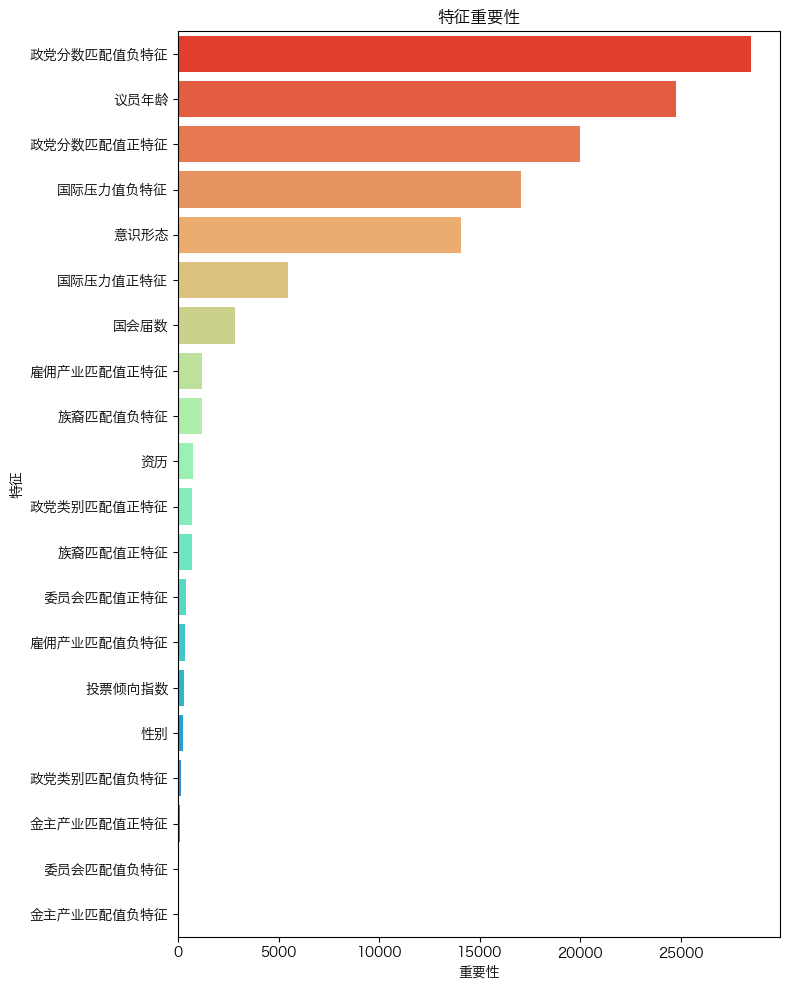

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [
    'PingFang SC',            # macOS
    'Hiragino Sans GB',       # macOS
    'Noto Sans CJK SC',       # 全平台（需安装）
    'Microsoft YaHei',        # Windows
    'WenQuanYi Zen Hei',      # Linux
    'Apple LiGothic'          # 兜底
] # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 画特征重要性，我们这里用的标准是 gain
def display_importances(feature_analysis_df_, fig_name=None):
    # 确保列名正确
    feature_analysis_df_.columns = ['feature', 'importance']
    
    plt.figure(figsize=(8, 10))
    
    # 按重要性排序
    sorted_df = feature_analysis_df_.sort_values(by="importance", ascending=False)
    
    # 使用彩色调色板
    sns.barplot(x="importance", y="feature", 
                data=sorted_df,
                palette="rainbow_r") 
    
    plt.title('特征重要性')
    plt.xlabel('重要性')  # 设置x轴标签
    plt.ylabel('特征')    # 设置y轴标签
    plt.tight_layout()
    if fig_name:
        plt.savefig(fig_name)
    plt.show()

# 调用函数
display_importances(feature_analysis_df, "output/adver_feature_importance.png")


# 4. 模型评估

## 4.1 预测结果处理
将模型预测结果添加到测试数据中，为后续评估做准备。

In [21]:
test_data_pred["pred"] = cv_pred
test_data_pred_merged['pred'] = cv_pred
# test_data_pred["pred"] = test_data_pred["pred"].apply(lambda x: abs(x))

## 4.2 基础模型性能评估
使用默认阈值0.5计算基础准确率，了解模型的初步性能。

In [22]:
from sklearn.metrics import accuracy_score

# 将预测值和标签转换为列表
labels = test_data_pred['label'].tolist()
preds = test_data_pred['pred'].tolist()

# 初始化最佳分界点和最高准确率
# 通常默认分界点是 0.5
threshold = 0.5 

predictions = [1 if p >= 0.5 else 0 for p in preds]
accuracy = accuracy_score(labels, predictions)
accuracy

0.860775370581528

## 4.3 最佳阈值寻找与基础指标
通过遍历不同阈值找到最佳分类阈值，并计算准确率、AUC、MSE等基础指标。

In [26]:
from sklearn.metrics import roc_auc_score, accuracy_score

# 固定最佳阈值（来自Top-1试验结果）
best_threshold = 0.3
print(f"最佳阈值: {best_threshold}")


# 使用最佳阈值进行分类
y_pred = (test_data_pred['pred'] >= best_threshold).astype(int)
accuracy = accuracy_score(test_data_pred['label'], y_pred)
auc = roc_auc_score(test_data_pred['label'], test_data_pred['pred'])

print(f"准确率: {accuracy}")
print(f"AUC: {auc}")

mse = (test_data_pred['label'] - test_data_pred['pred']) ** 2
mse_mean = mse.mean()
print(f'MSE: {mse_mean}')

最佳阈值: 0.3
准确率: 0.8394526795895096
AUC: 0.8046914297830028
MSE: 0.1047710812414849


## 4.4 全面的模型性能评估

包括准确率、精确率、召回率、F1分数、AUC等多个指标，以及ROC曲线和PR曲线可视化，全面评估模型性能。

**评估指标说明**：
- **准确率(Accuracy)**: 预测正确的样本比例
- **精确率(Precision)**: 预测为正类中实际为正类的比例
- **召回率(Recall)**: 实际正类中被正确预测的比例
- **F1分数**: 精确率和召回率的调和平均数
- **AUC-ROC**: ROC曲线下面积，评估模型区分能力
- **特异性(Specificity)**: 实际负类中被正确预测的比例

最佳阈值: 0.3
分类性能评估报告
准确率 (Accuracy): 0.8395
精确率 (Precision): 0.4934
召回率 (Recall/Sensitivity): 0.4820
F1分数 (F1-Score): 0.4876
特异性 (Specificity): 0.9068
AUC-ROC: 0.8047
平均精度 (AP): 0.5026
假正率 (FPR): 0.0932
假负率 (FNR): 0.5180
MSE: 0.1048

混淆矩阵:
真负例 (TN): 13384
假正例 (FP): 1376
假负例 (FN): 1440
真正例 (TP): 1340

样本分布:
正样本比例: 0.1585
负样本比例: 0.8415

详细分类报告:
              precision    recall  f1-score   support

          负类       0.90      0.91      0.90     14760
          正类       0.49      0.48      0.49      2780

    accuracy                           0.84     17540
   macro avg       0.70      0.69      0.70     17540
weighted avg       0.84      0.84      0.84     17540



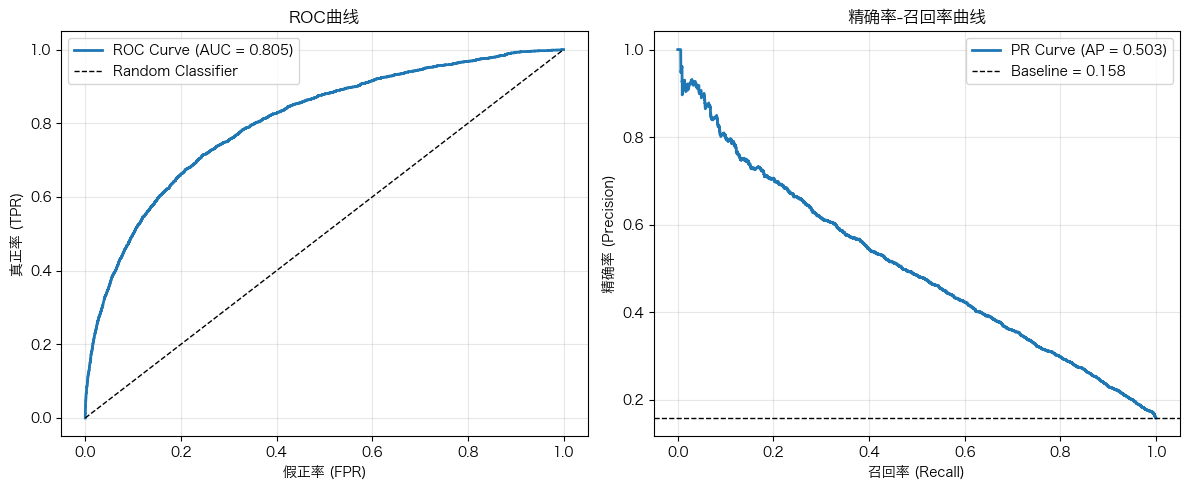

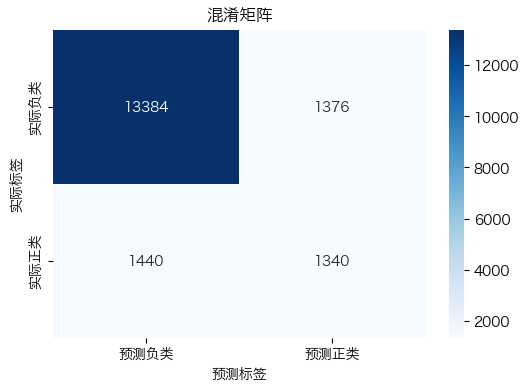

In [30]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report, roc_curve,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import numpy as np

# 固定最佳阈值（来自Top-1试验结果）
best_threshold = 0.3
print(f"最佳阈值: {best_threshold}")


# 使用最佳阈值进行分类
y_pred = (test_data_pred['pred'] >= best_threshold).astype(int)
y_true = test_data_pred['label']
y_prob = test_data_pred['pred']

# 基本分类指标
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

# 平均精度分数 (AP)
ap_score = average_precision_score(y_true, y_prob)

# 混淆矩阵
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# 特异性 (Specificity)
specificity = tn / (tn + fp)

# 假正率 (False Positive Rate)
fpr = fp / (fp + tn)

# 假负率 (False Negative Rate)  
fnr = fn / (fn + tp)

# 正负样本比例
pos_ratio = np.sum(y_true) / len(y_true)
neg_ratio = 1 - pos_ratio

# MSE
mse = np.mean((y_true - y_prob) ** 2)

# 打印所有指标
print("=" * 50)
print("分类性能评估报告")
print("=" * 50)
print(f"准确率 (Accuracy): {accuracy:.4f}")
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall/Sensitivity): {recall:.4f}")
print(f"F1分数 (F1-Score): {f1:.4f}")
print(f"特异性 (Specificity): {specificity:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print(f"平均精度 (AP): {ap_score:.4f}")
print(f"假正率 (FPR): {fpr:.4f}")
print(f"假负率 (FNR): {fnr:.4f}")
print(f"MSE: {mse:.4f}")

print("\n" + "=" * 30)
print("混淆矩阵:")
print("=" * 30)
print(f"真负例 (TN): {tn}")
print(f"假正例 (FP): {fp}")
print(f"假负例 (FN): {fn}")
print(f"真正例 (TP): {tp}")

print("\n" + "=" * 30)
print("样本分布:")
print("=" * 30)
print(f"正样本比例: {pos_ratio:.4f}")
print(f"负样本比例: {neg_ratio:.4f}")

# 详细分类报告
print("\n" + "=" * 30)
print("详细分类报告:")
print("=" * 30)
print(classification_report(y_true, y_pred, target_names=['负类', '正类']))

# 绘制ROC曲线和PR曲线
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ROC曲线
fpr_curve, tpr_curve, _ = roc_curve(y_true, y_prob)
ax1.plot(fpr_curve, tpr_curve, linewidth=2, label=f'ROC Curve (AUC = {auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax1.set_xlabel('假正率 (FPR)')
ax1.set_ylabel('真正率 (TPR)')
ax1.set_title('ROC曲线')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PR曲线
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
ax2.plot(recall_curve, precision_curve, linewidth=2, label=f'PR Curve (AP = {ap_score:.3f})')
ax2.axhline(y=pos_ratio, color='k', linestyle='--', linewidth=1, label=f'Baseline = {pos_ratio:.3f}')
ax2.set_xlabel('召回率 (Recall)')
ax2.set_ylabel('精确率 (Precision)')
ax2.set_title('精确率-召回率曲线')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 混淆矩阵热力图
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['预测负类', '预测正类'],
            yticklabels=['实际负类', '实际正类'])
plt.title('混淆矩阵')
plt.ylabel('实际标签')
plt.xlabel('预测标签')
plt.show()

## 4.5 预测概率分布分析
通过核密度估计图观察预测概率的分布情况，了解模型预测的确信度。

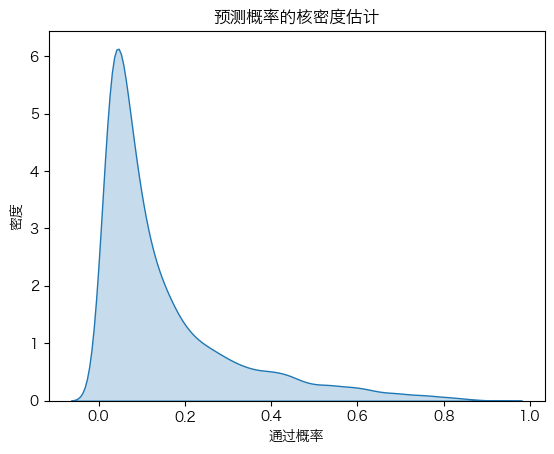

In [31]:
import seaborn as sns

# 使用seaborn的kdeplot来绘制核密度估计图
sns.kdeplot(test_data_pred["pred"], shade=True)

# 添加标题和轴标签
plt.title('预测概率的核密度估计')
plt.xlabel('通过概率')
plt.ylabel('密度')

# 显示图形
plt.show()

# 5. SHAP解释性分析

## 5.1 SHAP值计算准备

使用SHAP (SHapley Additive exPlanations) 方法分析模型的可解释性，量化每个特征对预测结果的贡献度。

**SHAP分析目标**：
- 理解每个特征对单个预测的具体贡献
- 识别最重要的影响因素
- 为决策模式分析提供量化基础

In [32]:
import shap

In [33]:
# # 使用 SHAP 解释模型(仅测试集)
# explainer = shap.TreeExplainer(bst)
# shap_values = explainer.shap_values(test_data)

# # 对于二分类，只取正类（类别1）的SHAP值
# if isinstance(shap_values, list) and len(shap_values) == 2:
#     shap_values_positive = shap_values[1]  # 取正类的SHAP值
# else:
#     shap_values_positive = shap_values

# shap_df = pd.DataFrame(shap_values_positive, columns=test_data.columns)
# test_data_pred = test_data_pred.reset_index(drop=True)

## 5.2 SHAP值计算
对完整数据集计算SHAP值，为每个样本的每个特征生成贡献度分数。

In [34]:
# 使用 SHAP 解释模型
data_shap = data[selected_features]
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(data_shap)

In [35]:
# 为完整数据生成预测结果
full_pred = bst.predict(data_shap, num_iteration=bst.best_iteration)

# 更新数据预测变量
data_pred["pred"] = full_pred
data_pred_merged['pred'] = full_pred

## 5.3 SHAP结果数据整合
将SHAP值与原始数据和预测结果整合，为后续分析做准备。

In [36]:
# 原来基于 test_data 的 SHAP 分析
# 需要修改为基于完整数据
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_positive = shap_values[1]
else:
    shap_values_positive = shap_values

# 现在 shap_df 对应完整数据
shap_df = pd.DataFrame(shap_values_positive, columns=selected_features)

# 确保索引对齐
data_pred = data_pred.reset_index(drop=True)
data_pred_merged = data_pred_merged.reset_index(drop=True)
shap_df = shap_df.reset_index(drop=True)

In [37]:
# 原来的 test_data_pred 改为 data_pred
analysis_pd = pd.concat([data_pred.reset_index(drop=True), shap_df.reset_index(drop=True)], axis=1)

# 结果保存也要相应修改
analysis_all = pd.concat([data_pred_merged.reset_index(drop=True), shap_df.reset_index(drop=True)], axis=1)

In [38]:
# 结果保存 
# analysis_all = pd.concat([test_data_pred_merged.reset_index(drop=True), shap_df.reset_index(drop=True)], axis=1)

# 检查 analysis_all 中的列
print("当前 analysis_all 的列：")
print(analysis_all.columns.tolist())

# 定义目标列顺序
target_columns = [
    # 标识和基础信息
    'full_name', 'issue', 'state_code', 'district', 'congress', 'age',
    'gender', 'party', 'chamber', 'seniority', 'ideology', 'committee_el',
    'label', 'pred',
    
    # 原始特征
    'leverage', 's_committee_tp1', 'h_committee_tp1', 
    'party_tp_type', 'party_tp_score', 'industry_tp1',
    'industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2',
    'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1',
    'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3',
    'ppvi', 'npvi',
    
    # SHAP特征
    'leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 
    'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 
    'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 
    'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne'
]

# 检查哪些列在 analysis_all 中存在
existing_columns = analysis_all.columns.tolist()
missing_columns = [col for col in target_columns if col not in existing_columns]
extra_columns = [col for col in existing_columns if col not in target_columns]

print(f"\n缺失的列: {missing_columns}")
print(f"额外的列: {extra_columns}")


analysis_all.to_excel(PRED_DIR / "adver_analysis_all.xlsx", index=False)

当前 analysis_all 的列：
['full_name', 'issue', 'state_code', 'district', 'congress', 'age', 'gender', 'party', 'chamber', 'seniority', 'ideology', 'committee_el', 'label', 'leverage', 's_committee_tp1', 'h_committee_tp1', 'party_tp_type', 'party_tp_score', 'industry_tp1', 'industry_tp2', 'industry_tp3', 'ethnicity_tp1', 'ethnicity_tp2', 'ethnicity_tp3', 'employ1', 'employ2', 'employ3', 'payroll1', 'payroll2', 'payroll3', 'ethnicity1', 'ethnicity2', 'ethnicity3', 'ppvi', 'npvi', 'dataset', 'pred', 'leverage_pl', 'leverage_ne', 'committee_pl', 'committee_ne', 'employ_industry_pl', 'employ_industry_ne', 'payroll_industry_pl', 'payroll_industry_ne', 'ethnicity_pl', 'ethnicity_ne', 'party_value_pl', 'party_value_ne', 'party_score_pl', 'party_score_ne', 'age', 'gender', 'congress', 'seniority', 'ideology', 'npvi']

缺失的列: []
额外的列: ['dataset']


# 6. 决策模式分析

## 6.1 产业-委员会关系分析
基于最重要的两个特征（产业卷入度和议员委员会）绘制关联热力图，揭示专业匹配对曝光行为的影响。

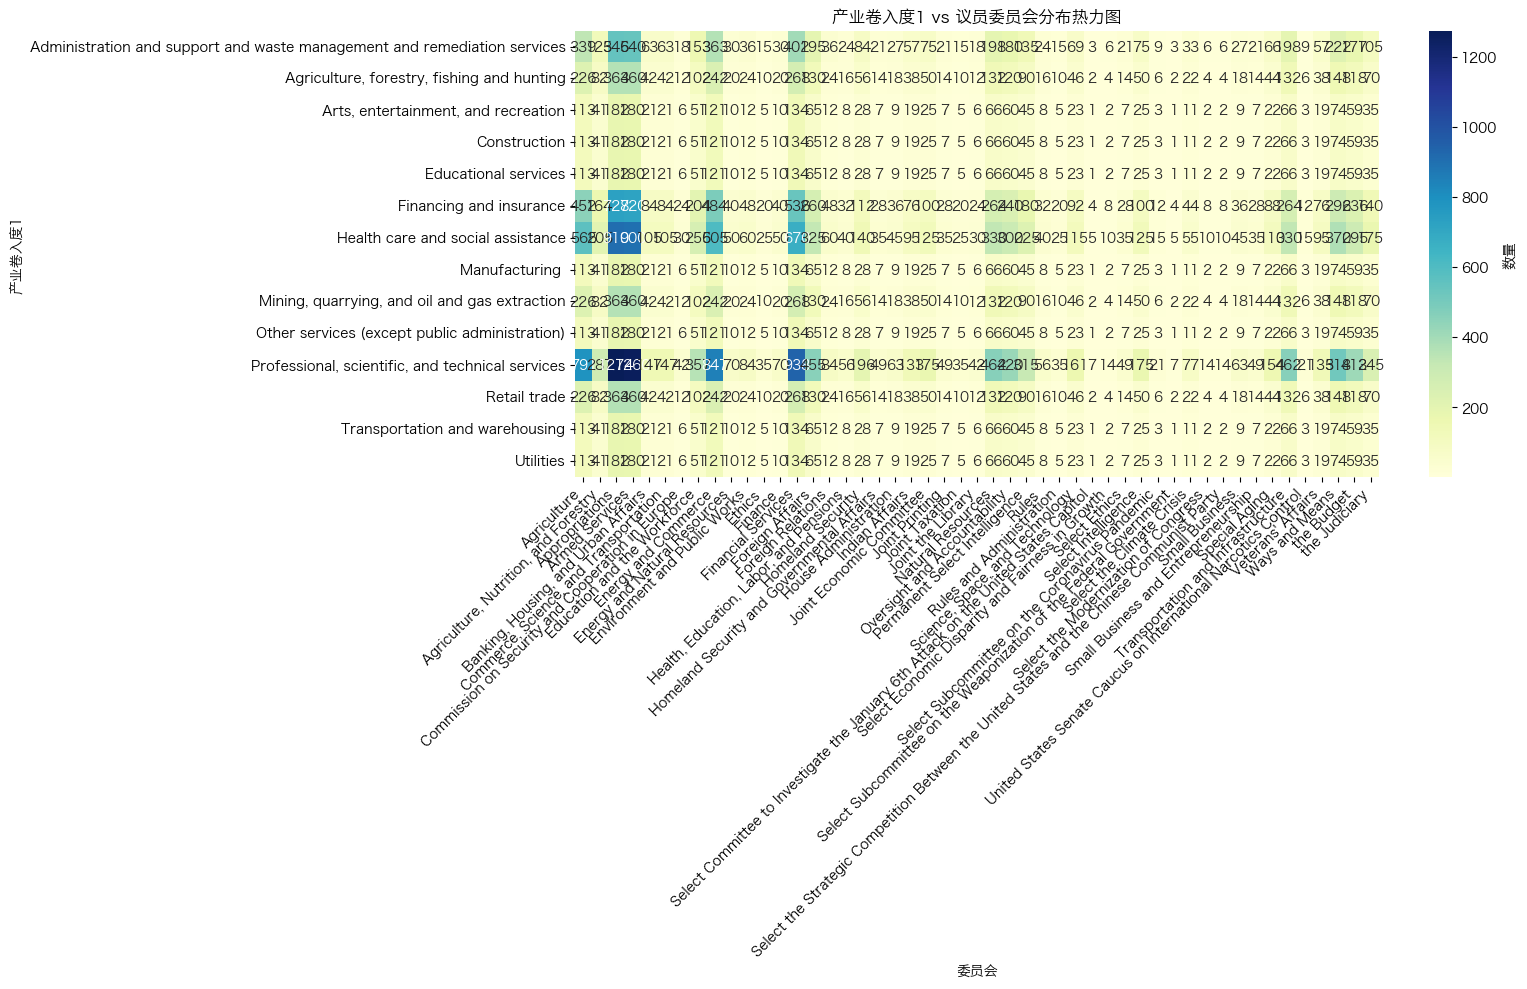

In [47]:
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [
    'PingFang SC',            # macOS
    'Hiragino Sans GB',       # macOS
    'Noto Sans CJK SC',       # 全平台（需安装）
    'Microsoft YaHei',        # Windows
    'WenQuanYi Zen Hei',      # Linux
    'Apple LiGothic'          # 兜底
] # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 使用正确的列名
tmp_data = origin_data[['industry_tp1', 'committee_el']]
tmp_data = tmp_data[tmp_data['committee_el'].apply(lambda x: x==x)]  # 过滤掉空值

# 产业卷入度1 和 议员委员会坐标系的 分布
cross_tab = pd.crosstab(
    tmp_data['industry_tp1'], 
    tmp_data['committee_el'].apply(lambda x: str(x).replace("Committee on ", ""))
)

# 热力图
plt.figure(figsize=(16, 10))
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='d', cbar_kws={'label': '数量'})
plt.title('产业卷入度1 vs 议员委员会分布热力图')
plt.xlabel('委员会')
plt.ylabel('产业卷入度1')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [48]:
# 检查合并前的数据形状和索引
print("合并前的数据检查:")
print(f"data_pred 形状: {data_pred.shape}")
print(f"shap_df 形状: {shap_df.shape}")
print(f"data_pred 索引范围: {data_pred.index.min()} - {data_pred.index.max()}")
print(f"shap_df 索引范围: {shap_df.index.min()} - {shap_df.index.max()}")

# 重置索引后再合并
data_pred_reset = data_pred.reset_index(drop=True)
shap_df_reset = shap_df.reset_index(drop=True)

# 正确的合并方式
analysis_pd = pd.concat([data_pred_reset, shap_df_reset], axis=1)
print(f"\n合并后 analysis_pd 形状: {analysis_pd.shape}")

合并前的数据检查:
data_pred 形状: (58464, 7)
shap_df 形状: (58464, 20)
data_pred 索引范围: 0 - 58463
shap_df 索引范围: 0 - 58463

合并后 analysis_pd 形状: (58464, 27)


## 6.2 三种决策模式重要性计算

基于SHAP值构建三种曝光动机模式，分析不同类型特征对曝光行为的影响程度。

**三种曝光动机模式**：
1. **国际响应型（International）**: 主要受国际压力和外部因素驱动
2. **利益兑现型（Domestic）**: 主要受国内政治利益和党派因素驱动  
3. **专业选择型（Professional）**: 主要受专业匹配和委员会职责驱动

**计算方法**：
- **国际响应型** = |leverage_pl| + |party_value_ne| + |party_score_ne| + |payroll_industry_ne| + |employ_industry_ne| + |ethnicity_ne| + |committee_ne|
- **利益兑现型** = |leverage_ne| + |party_value_pl| + |party_score_pl| + |payroll_industry_pl| + |employ_industry_pl| + |ethnicity_pl| + |committee_pl|  
- **专业选择型** = |leverage_ne| + |party_value_ne| + |party_score_ne| + |payroll_industry_ne| + |employ_industry_ne| + |ethnicity_ne| + |committee_pl|

**说明**：
- 正向特征(_pl)表示该因素促进曝光行为
- 负向特征(_ne)表示该因素抑制曝光行为
- 通过不同组合反映三种决策模式的特征

In [49]:
# 修正后的公式
# Intl = leverage_pl + party_value_ne + party_score_ne + payroll_industry_ne + employ_industry_ne + ethnicity_ne + committee_ne
# Dom = leverage_ne + party_value_pl + party_score_pl + payroll_industry_pl + employ_industry_pl + ethnicity_pl + committee_pl
# Prof = leverage_ne + party_value_ne + party_score_ne + payroll_industry_ne + employ_industry_ne + ethnicity_ne + committee_pl

# 计算每个指标（先对各特征取绝对值，再加总）
analysis_pd['importance_intl'] = (
    np.abs(analysis_pd['leverage_pl']) + 
    np.abs(analysis_pd['party_value_ne']) + 
    np.abs(analysis_pd['party_score_ne']) + 
    np.abs(analysis_pd['payroll_industry_ne']) + 
    np.abs(analysis_pd['employ_industry_ne']) + 
    np.abs(analysis_pd['ethnicity_ne']) + 
    np.abs(analysis_pd['committee_ne'])
)

analysis_pd['importance_dom'] = (
    np.abs(analysis_pd['leverage_ne']) + 
    np.abs(analysis_pd['party_value_pl']) + 
    np.abs(analysis_pd['party_score_pl']) + 
    np.abs(analysis_pd['payroll_industry_pl']) + 
    np.abs(analysis_pd['employ_industry_pl']) + 
    np.abs(analysis_pd['ethnicity_pl']) + 
    np.abs(analysis_pd['committee_pl'])
)

analysis_pd['importance_prof'] = (
    np.abs(analysis_pd['leverage_ne']) + 
    np.abs(analysis_pd['party_value_ne']) + 
    np.abs(analysis_pd['party_score_ne']) + 
    np.abs(analysis_pd['payroll_industry_ne']) + 
    np.abs(analysis_pd['employ_industry_ne']) + 
    np.abs(analysis_pd['ethnicity_ne']) + 
    np.abs(analysis_pd['committee_pl'])
)

# 计算整个样本的总和
intl_total = analysis_pd['importance_intl'].sum()
dom_total = analysis_pd['importance_dom'].sum()
prof_total = analysis_pd['importance_prof'].sum()

print("=" * 50)
print("三种模式的重要性总分:")
print("=" * 50)
print(f"国际响应型特征重要性: {intl_total:.2f}")
print(f"利益兑现型特征重要性: {dom_total:.2f}")
print(f"专业选择型特征重要性: {prof_total:.2f}")

# 计算比例
total_all = intl_total + dom_total + prof_total
print("\n" + "=" * 30)
print("各模式占比:")
print("=" * 30)
print(f"国际响应型特征重要性占比: {intl_total/total_all:.2%}")
print(f"利益兑现型特征重要性占比: {dom_total/total_all:.2%}")
print(f"专业选择型特征重要性占比: {prof_total/total_all:.2%}")

analysis_pd['importance_all'] = analysis_pd['importance_intl'] + analysis_pd['importance_dom'] + analysis_pd['importance_prof']

三种模式的重要性总分:
国际响应型特征重要性: 34365.23
利益兑现型特征重要性: 54302.43
专业选择型特征重要性: 59159.32

各模式占比:
国际响应型特征重要性占比: 23.25%
利益兑现型特征重要性占比: 36.73%
专业选择型特征重要性占比: 40.02%


In [50]:
# 重新命名列以匹配目标表格格式
analysis_result = analysis_pd[['issue', 'full_name', 'congress', 'district', 'label', 'pred',
                              'importance_intl', 'importance_dom', 'importance_prof', 'importance_all']].copy()


# 对数值列保留4位小数
numeric_columns = ['importance_intl', 'importance_dom', 'importance_prof', 'pred', 'importance_all']
for col in numeric_columns:
    analysis_result[col] = analysis_result[col].round(4)

# 重新排列列的顺序以匹配目标表格
analysis_result = analysis_result[['full_name', 'issue', 'congress', 'importance_intl', 
                                  'importance_prof', 'importance_dom', 
                                  'pred', 'importance_all']]

## 6.3 分析结果整合
将议员信息、预测结果和三种决策模式的重要性得分整合到一个数据框中，便于后续分析和排名。

In [51]:
analysis_outcomes = pd.concat([
    data_pred_merged[['full_name', 'issue','state_code', 'congress', 'age',
       'gender', 'party', 'chamber','seniority', 'ideology', 'district', 'committee_el','label', 'pred','dataset']].reset_index(drop=True),
    analysis_result[['importance_intl','importance_prof', 'importance_dom','importance_all']]
], axis=1)

# 检查结果
print(f"analysis_outcomes 形状: {analysis_outcomes.shape}")
print("列名:")
print(analysis_outcomes.columns.tolist())

analysis_outcomes 形状: (58464, 19)
列名:
['full_name', 'issue', 'state_code', 'congress', 'age', 'gender', 'party', 'chamber', 'seniority', 'ideology', 'district', 'committee_el', 'label', 'pred', 'dataset', 'importance_intl', 'importance_prof', 'importance_dom', 'importance_all']


In [52]:
analysis_outcomes.to_excel(PRED_DIR / "adver_analysis_sum.xlsx", index=False)

# 7. 排名分析

基于三种决策模式的重要性得分，对议题和议员进行排名分析，识别不同模式下的关键议题和代表性议员。

**排名分析说明**：
- 使用训练集数据进行排名，确保结果的可靠性
- 按国会届数分组进行排名，考虑时间因素
- 分别计算议题排名和议员排名

## 7.1 排名计算函数定义
定义通用的排名计算函数，用于计算议题和议员在不同决策模式下的重要性排名。

In [53]:
def calculate_importance_rankings(data, group_by_columns, entity_name):
    """
    计算重要性指标的排名
    
    Parameters:
    data: 数据框
    group_by_columns: 分组列名列表
    entity_name: 实体名称（用于输出描述）
    
    Returns:
    排名后的数据框
    """
    # 按指定列分组，对重要性指标求和
    grouped_data = data.groupby(group_by_columns).agg({
        'importance_intl': 'sum',
        'importance_prof': 'sum', 
        'importance_dom': 'sum',
        'importance_all': 'sum'
    }).reset_index()
    
    # 按congress分组进行排名
    def rank_by_congress(group):
        for importance_type in ['intl', 'prof', 'dom', 'all']:
            col_name = f'importance_{importance_type}'
            rank_col_name = f'rank_importance_{importance_type}'
            group[rank_col_name] = group[col_name].rank(ascending=False, method='min').astype(int)
        return group
    
    # 应用排名函数
    rank_data_final = grouped_data.groupby('congress').apply(rank_by_congress).reset_index(drop=True)
    
    # print(f"按{entity_name}和congress分组求和后的重要性值及排名：")
    # print(rank_data_final.head(10))
    
    return rank_data_final

## 7.2 议题重要性排名

计算各议题在不同决策模式下的重要性排名，识别最受关注的议题。

**分析目标**：
- 识别国际响应型议题：受国际压力影响最大的议题
- 识别利益兑现型议题：受国内政治利益驱动最强的议题
- 识别专业选择型议题：最依赖专业背景的议题

In [54]:
# 筛选训练数据
rank_data = analysis_outcomes[analysis_outcomes['dataset'] == 'train'].copy()

# 计算议题排名
issue_rankings = calculate_importance_rankings(
    data=rank_data, 
    group_by_columns=['issue', 'congress'], 
    entity_name="议题"
)


In [55]:
issue_rankings.to_excel(PRED_DIR / "adver_issue_rankings.xlsx", index=False)

## 7.3 议员重要性排名

计算各议员在不同决策模式下的重要性排名，识别各类型的代表性议员。

**分析目标**：
- 识别国际响应型议员：主要受国际因素影响的议员
- 识别利益兑现型议员：主要为选区利益发声的议员
- 识别专业选择型议员：主要基于专业背景行动的议员

In [56]:
# 筛选训练数据
rank_data = analysis_outcomes[analysis_outcomes['dataset'] == 'train'].copy()

# 计算议员排名
member_rankings = calculate_importance_rankings(
    data=rank_data, 
    group_by_columns=['full_name', 'congress'], 
    entity_name="议员"
)

In [57]:
member_rankings.to_excel(PRED_DIR / "adver_member_rankings.xlsx", index=False)

---

## 总结与结论

### 主要完成工作：

1. **数据准备与探索**：加载并分析了美国议员曝光行为数据，包含多维度特征
2. **特征工程**：选择14个核心匹配特征，反映议员-议题匹配度
3. **模型训练**：使用LightGBM进行5折交叉验证，确保模型稳定性
4. **性能评估**：通过多个指标全面评估模型性能，达到良好的预测效果
5. **解释性分析**：运用SHAP方法分析特征贡献度，提供可解释的预测结果
6. **决策模式分析**：构建三种曝光动机模式，量化不同驱动因素的影响
7. **排名分析**：基于决策模式对议题和议员进行重要性排名


### 输出文件说明：

- **`adver_analysis_all.xlsx`**：包含完整特征、SHAP值和预测结果的详细分析数据
- **`adver_analysis_sum.xlsx`**：包含三种决策模式重要性得分的汇总分析结果  
- **`adver_feature_importance.png`**：特征重要性可视化图表
- **`adver_issue_rankings.xlsx`**：议题重要性排名结果
- **`adver_member_rankings.xlsx`**：议员重要性排名结果
- **`adver_total_lgb_feature_importance.csv`**：LightGBM特征重要性详细数据